In [1]:
import time
import os
import gc
import math
import cv2
import numpy as np
import pandas as pd
import pyautogui as pa
import shutil
import re  # regex
from PIL import Image, ImageDraw
import random
from scipy.stats import sem, ttest_ind, norm, ttest_ind_from_stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import imageio
from sklearn.cluster import KMeans

from lib.analysis.trace_metrics import TraceMetrics
from lib.analysis.false_discovery_control import false_discovery_control
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.analysis.align import ImageAlign
from lib.file.ROI_writer import ROIFileWriter
from lib.analysis.barrel_roi import Barrel_ROI_Creator
from lib.analysis.cell_roi import RandomROISample, OverlapCounterROI
from lib.analysis.baseline_correction import BaselineCorrection

# 2-way ANOVA for medial and lateral PPR vs IPI
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm

from lib.utilities import *
from lib.file.TIF import *

from ZDA_Adventure.utility import ROIFileReader

try:
    from PPR_PV_anna_Dec2025_progress import rec_id_skip_list
except ImportError:
    rec_id_skip_list = []


In [ ]:
# Load data, not from Drive for Desktop since PhotoZ complains about loading zda from Drive
data_dir = "P:/John/analyzed_archived/crossing_PPR/crossing_PPR/"
camera_program = 4
which_rig = 'new' 
date_format = 'yy-mm-dd'
if which_rig == 'old':
    date_format = 'yyyy-mm-dd'

# annotation settings
output_fig_dir = data_dir + 'velocity_vectors_Jan2026/'



In [9]:
# load PPR catalog
ppr_catalog = data_dir + "ppr_catalog.csv"
ppr_catalog_df = pd.read_csv(ppr_catalog)

# only keep zda_file, IPI, and Stim_Layer columns
ppr_catalog_df = ppr_catalog_df[['zda_file', 'IPI', 'Stim_Layer', 'Sex', 'Age']]

# parse slice, location, and recording numbers from zda_file and store in new columns
ppr_catalog_df['zda_id'] = ppr_catalog_df['zda_file'].apply(lambda x: x.split('/')[-1].split('.')[0])
ppr_catalog_df['Slice'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[0]))
ppr_catalog_df['Location'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[1]))
ppr_catalog_df['Recording'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[2]))

# parse date from zda_file column. It is in format "/mm-dd-yy/", use pattern matching to extract date (regex)
# Function to extract date using regex
def extract_date(filename):
    match = re.search(r'(\d{2}-\d{2}-\d{2})', filename)
    if match:
        # remove zero padding from day and month
        m,d,y = match.group(0).split('-')
        d = str(int(d))
        m = str(int(m))
        return f"{m}-{d}-{int(y)}"
    return None

ppr_catalog_df['Date'] = ppr_catalog_df['zda_file'].apply(extract_date)
ppr_catalog_df

,zda_file,IPI,Stim_Layer,Sex,Age,zda_id,Slice,Location,Recording,Date
0,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,20,L4,M,69,01_01_01,1,1,1,22-9-2
1,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,50,L4,M,69,01_01_02,1,1,2,22-9-2
2,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,100,L4,M,69,01_01_03,1,1,3,22-9-2
3,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,100,L2/3,M,69,01_02_01,1,2,1,22-9-2
4,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,20,L2/3,M,69,01_02_02,1,2,2,22-9-2
...,...,...,...,...,...,...,...,...,...,...
1481,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,50,L5,F,72,07_02_04,7,2,4,23-9-17
1482,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,50,L2/3,F,72,07_03_01,7,3,1,23-9-17
1483,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,100,L2/3,F,72,07_03_02,7,3,2,23-9-17
1484,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,200,L2/3,F,72,07_03_03,7,3,3,23-9-17


In [ ]:
def read_array_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Values'])
    return np.array(data_arr['Values']).reshape((80, 80))

def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)  # change me to traces?
    data_arr = data_arr.apply(pd.to_numeric, errors='coerce')
    return data_arr


,ROI,amp,latency,halfwidth,X_Center,Y_Center,ROI_Set,Date,Slice,Location,Recording,trace,amp_array,latency_array,stim_time,Section,IPI,Stim_Layer,Sex,Age
0,1,1.207785,50.832063,8.483424,35.750000,44.225460,analysis01_01_01\rois_layer_L23 pulse1,22-9-2,1,1,1,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,49.250083,Coronal,20.0,L4,M,69.0
1,2,0.904246,43.143071,16.047991,57.468284,30.994403,analysis01_01_01\rois_layer_L23 pulse1,22-9-2,1,1,1,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,49.250083,Coronal,20.0,L4,M,69.0
2,3,1.212838,51.424012,8.436819,14.868085,58.165957,analysis01_01_01\rois_layer_L23 pulse1,22-9-2,1,1,1,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,49.250083,Coronal,20.0,L4,M,69.0
3,1,1.035536,70.177967,4.190614,35.750000,44.225460,analysis01_01_01\rois_layer_L23 pulse2,22-9-2,1,1,1,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,69.250166,Coronal,20.0,L4,M,69.0
4,2,0.693921,65.399529,9.480184,57.468284,30.994403,analysis01_01_01\rois_layer_L23 pulse2,22-9-2,1,1,1,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,69.250166,Coronal,20.0,L4,M,69.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23239,2,1.255736,43.000000,12.829395,16.485255,48.501340,analysis07_03_04\rois_layer_L5 pulse1,23-9-17,7,3,4,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,49.250083,Coronal,20.0,L2/3,F,72.0
23240,3,1.211582,43.000000,17.754763,58.764550,17.724868,analysis07_03_04\rois_layer_L5 pulse1,23-9-17,7,3,4,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,49.250083,Coronal,20.0,L2/3,F,72.0
23241,1,2.503061,73.782214,6.164784,39.472160,33.385301,analysis07_03_04\rois_layer_L5 pulse2,23-9-17,7,3,4,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,69.250579,Coronal,20.0,L2/3,F,72.0
23242,2,1.967337,73.313998,7.141040,16.485255,48.501340,analysis07_03_04\rois_layer_L5 pulse2,23-9-17,7,3,4,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_...,69.250579,Coronal,20.0,L2/3,F,72.0


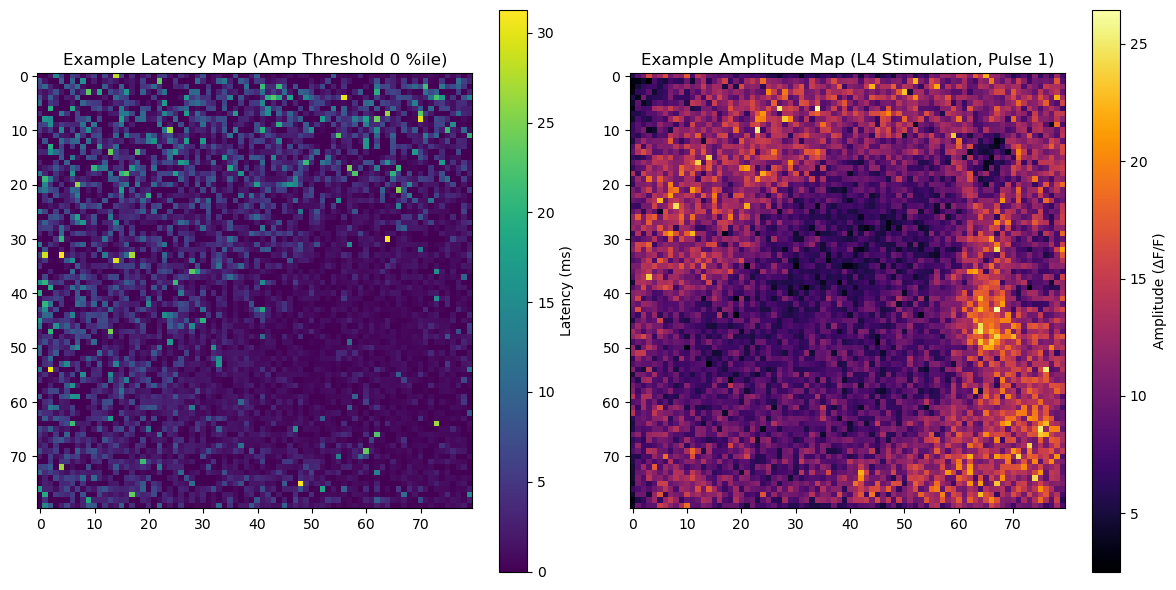

Number of initial candidate ROIs in example latency map: 29
Number of ROIs after size filter: 28
Number of ROIs after composite cluster label consistency filter: 19


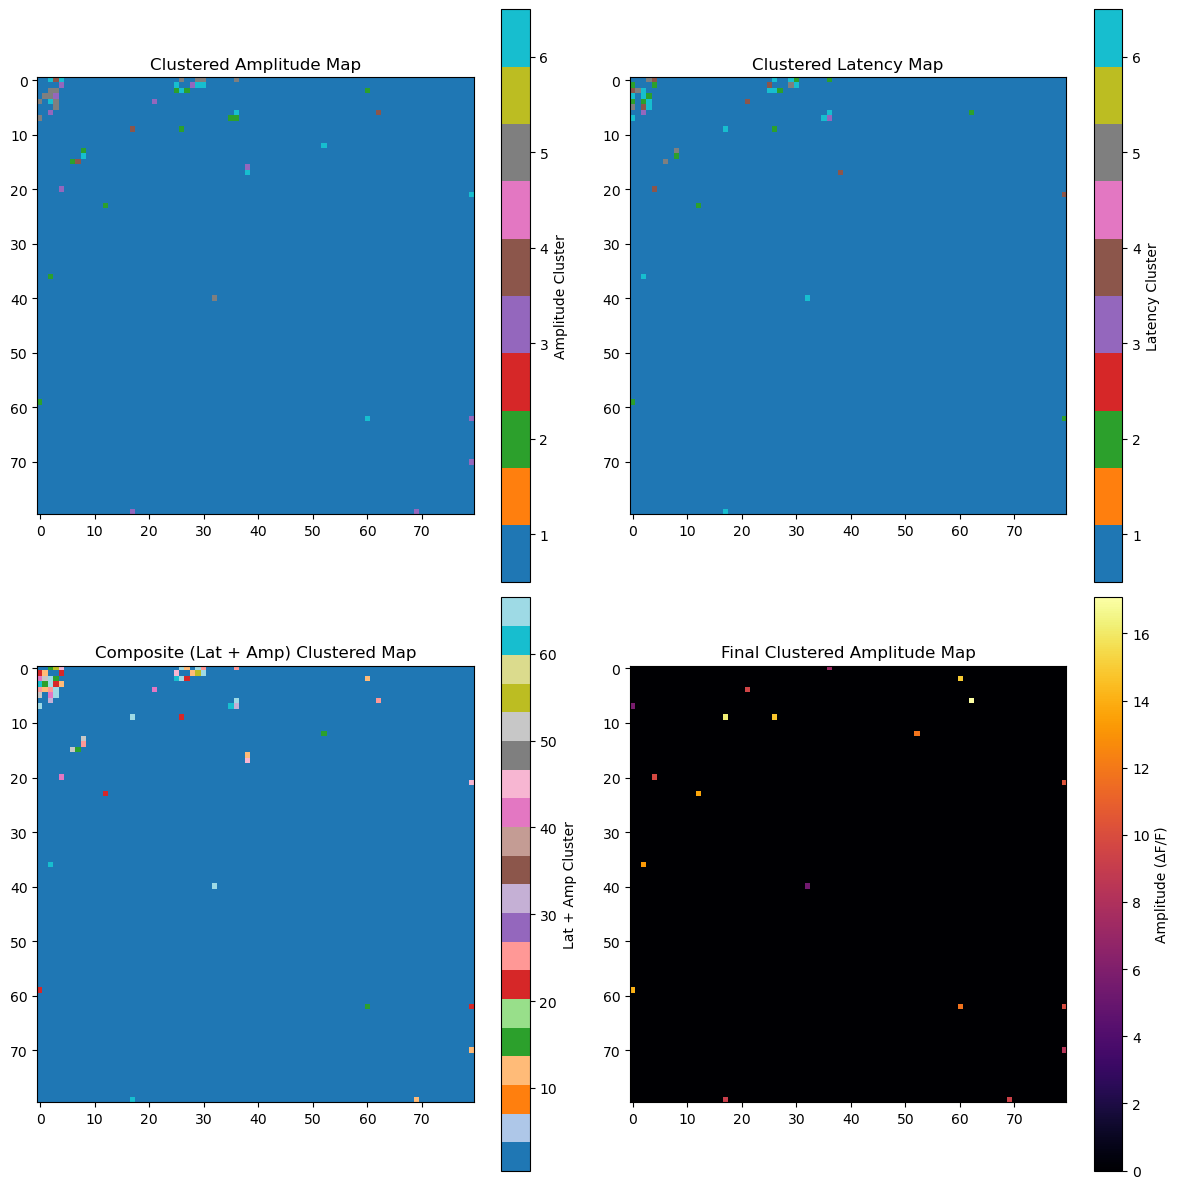

Number of ROIs after latency cluster filter: 19
Number of ROIs after amplitude cluster filter: 19


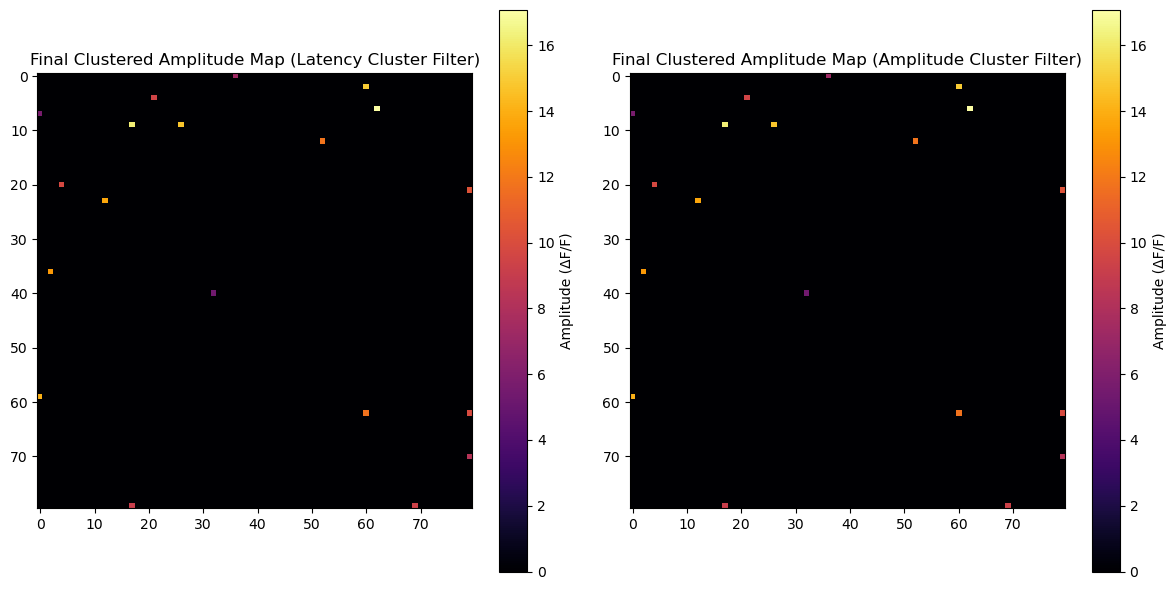

In [25]:
# latency map  example
example_data_dir = 'C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_PVCre/'
example_lat_map_file = example_data_dir + '2022-09-16/_01_01_02_latency_array_analysis01_01_02_rois_layer_L4_pulse1.dat'
example_amp_map_file = example_data_dir + '2022-09-16/_01_01_02_amp_array_analysis01_01_02_rois_layer_L4_pulse1.dat'
example_stim_time = 49.250165289256195
lat_map = read_array_file(example_lat_map_file) - example_stim_time
amp_map = read_array_file(example_amp_map_file)
k_means_num_clusters = 3
xth_percentile = 0
# mask out latencies where amp_map is less than its xth percentile
amp_threshold = np.percentile(amp_map[amp_map > 0], xth_percentile)
lat_map_masked = np.where(amp_map >= amp_threshold, lat_map, 0)

# mCherry example 2/20/24, 02_01_01
use_mCherry_example = True
if use_mCherry_example:
    example_data_dir = 'C:/Users/jjudge3/Desktop/Data/PV-PPR/mCherry-PV/'
    example_lat_map_file = example_data_dir + '02-20-24/zda/_02_01_01_latency_array_.dat'
    example_amp_map_file = example_data_dir + '02-20-24/zda/_02_01_01_amp_array_.dat'
    example_stim_time = 49.250165289256195
    lat_map = read_array_file(example_lat_map_file) - example_stim_time
    amp_map = read_array_file(example_amp_map_file)
    amp_threshold = np.percentile(amp_map[amp_map > 0], xth_percentile)
    lat_map_masked = np.where(amp_map >= amp_threshold, lat_map, 0)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(lat_map_masked, cmap='viridis', vmin=0)
plt.colorbar(label='Latency (ms)')
plt.title(f'Example Latency Map (Amp Threshold {xth_percentile} %ile)')
plt.subplot(1, 2, 2)
plt.imshow(amp_map, cmap='inferno')
plt.colorbar(label='Amplitude (ΔF/F)')
plt.title('Example Amplitude Map (L4 Stimulation, Pulse 1)')
plt.tight_layout()
plt.savefig(output_fig_dir + 'example_latency_amplitude_map.png')
plt.show()

def convert_mask_to_rois(mask):
    # convert a 2D mask array to a list of ROIs with their x,y coordinates
    # an ROI is a block of contiguous non-zero pixels
    
    rois = []
    visited_px_map = np.zeros_like(mask, dtype=bool)
    num_nonzero_px = np.sum(mask > 0)
    num_visited_px = 0
    while num_visited_px < num_nonzero_px:
        new_roi = []
        # find first unvisited non-zero pixel
        for y in range(mask.shape[0]):
            for x in range(mask.shape[1]):
                if mask[y, x] > 0 and not visited_px_map[y, x]:
                    new_roi.append((x, y))
                    visited_px_map[y, x] = True
                    num_visited_px += 1
                    break
            if len(new_roi) > 0:
                break
        # do a flood fill to find all contiguous non-zero pixels
        roi_index = 0
        while roi_index < len(new_roi):
            px_x, px_y = new_roi[roi_index]
            # check neighbors (up, down, left, right)
            neighbors = [(px_x-1, px_y), (px_x+1, px_y), (px_x, px_y-1), (px_x, px_y+1)]
            for n_x, n_y in neighbors:
                if (0 <= n_x < mask.shape[1]) and (0 <= n_y < mask.shape[0]):
                    if mask[n_y, n_x] > 0 and not visited_px_map[n_y, n_x]:
                        new_roi.append((n_x, n_y))
                        visited_px_map[n_y, n_x] = True
                        num_visited_px += 1
            roi_index += 1

        rois.append(new_roi)

    return rois

def convert_rois_to_mask(rois, shape):
    # convert a list of ROIs with their x,y coordinates to a 2D mask array
    mask = np.zeros(shape, dtype=int)
    for roi_index, roi in enumerate(rois):
        for px_x, px_y in roi:
            mask[px_y, px_x] = roi_index + 1  # ROI indices start at 1
    return mask

def cluster_rois_by_latency_and_amplitude(output_fig_dir, date_rec_id, lat_map_masked, amp_map, 
                                          max_roi_width=6, show_plots=False, create_plots=True,
                                          verbose=True):
    # cluster ROIs by their average latency and amplitude
    # return a list of clustered ROIs, and the number of candidate ROIs:
    #   initial candidate ROIs after SNR thresholding
    #   filtered ROIs after size filtering
    #   ROIs after latency clustering and consistency filtering
    #   ROIs after amplitude clustering and consistency filtering
    #   ROIs after composite clustering and consistency filtering

    # roi must fit into a square of size max_roi_width x max_roi_width
    roi_list = convert_mask_to_rois(lat_map_masked)
    filtered_roi_list = []
    for roi in roi_list:
        xs = [px[0] for px in roi]
        ys = [px[1] for px in roi]
        if (max(xs) - min(xs) + 1) <= max_roi_width and (max(ys) - min(ys) + 1) <= max_roi_width:
            filtered_roi_list.append(roi)

    n_rois_snr_threshold = len(roi_list)
    n_rois_size_filtered = len(filtered_roi_list)
    if verbose:
        print(f"Number of initial candidate ROIs in example latency map: {len(roi_list)}")
        print(f"Number of ROIs after size filter: {len(filtered_roi_list)}")

    mask_2 = convert_rois_to_mask(filtered_roi_list, lat_map_masked.shape)
    latencies_1D = lat_map[mask_2 > 0].flatten()
    amps_1D = amp_map[mask_2 > 0].flatten()

    # cluster latencies into 6 clusters using kmeans
    kmeans_lat = KMeans(n_clusters=6, random_state=0).fit(latencies_1D.reshape(-1, 1))
    labels_lat = kmeans_lat.labels_
    # create a new latency map with clustered latencies
    lat_map_clustered = np.zeros_like(lat_map_masked)
    lat_map_clustered[mask_2 > 0] = labels_lat + 1  # cluster labels start at 0, so add 1 for visualization

    # cluster amps into 6 clusters using kmeans
    kmeans_amp = KMeans(n_clusters=6, random_state=0).fit(amps_1D.reshape(-1, 1))
    labels_amp = kmeans_amp.labels_
    # create a new amplitude map with clustered amplitudes
    amp_map_clustered = np.zeros_like(amp_map)
    amp_map_clustered[mask_2 > 0] = labels_amp + 1  # cluster labels start at 0, so add 1 for visualization

    # composite cluster label = (latency cluster) * 10 + (amplitude cluster)
    composite_map = lat_map_clustered * 10 + amp_map_clustered

    # for filtered_roi_list, look at the composite cluster labels for each ROI
    # if it's not the case that all pixels in the ROI have the same composite label, filter it out
    final_roi_list = []
    for roi in filtered_roi_list:
        roi_labels = set()
        for px_x, px_y in roi:
            roi_labels.add(composite_map[px_y, px_x])
        if len(roi_labels) == 1 and 0 not in roi_labels:
            final_roi_list.append(roi)

    n_rois_composite_clustered = len(final_roi_list)
    if verbose:
        print(f"Number of ROIs after composite cluster label consistency filter: {len(final_roi_list)}")

    final_mask = convert_rois_to_mask(final_roi_list, lat_map_masked.shape)
    final_amp_map_clustered = np.zeros_like(amp_map)
    final_amp_map_clustered[final_mask > 0] = amp_map[final_mask > 0]
    final_lat_map_clustered = np.zeros_like(lat_map_masked)
    final_lat_map_clustered[final_mask > 0] = lat_map_masked[final_mask > 0]

    # plot clustered latency and amplitude maps
    if create_plots:
        plt.figure(figsize=(12, 12))
        plt.subplot(2, 2, 1)
        plt.imshow(amp_map_clustered, cmap='tab10', vmin=0.5, vmax=6.5)
        plt.colorbar(label='Amplitude Cluster')
        plt.title('Clustered Amplitude Map')
        plt.subplot(2, 2, 2)
        plt.imshow(lat_map_clustered, cmap='tab10', vmin=0.5, vmax=6.5)
        plt.colorbar(label='Latency Cluster')
        plt.title('Clustered Latency Map')
        plt.subplot(2, 2, 3)
        plt.imshow(composite_map, cmap='tab20', vmin=0.5, vmax=66.5)
        plt.colorbar(label='Lat + Amp Cluster')
        plt.title('Composite (Lat + Amp) Clustered Map')
        plt.subplot(2, 2, 4)
        plt.imshow(final_amp_map_clustered, cmap='inferno')
        plt.colorbar(label='Amplitude (ΔF/F)')
        plt.title('Final Clustered Amplitude Map')
        plt.tight_layout()
        plt.savefig(output_fig_dir + f'clustered_latency_and_amplitude_map_{date_rec_id}.png')
        if show_plots:
            plt.show()
        plt.close()

    # alterative final list: filter by latency cluster only, not composite
    final_roi_list_2 = []
    for roi in filtered_roi_list:
        roi_labels = set()
        for px_x, px_y in roi:
            roi_labels.add(lat_map_clustered[px_y, px_x])
        if len(roi_labels) == 1 and 0 not in roi_labels:
            final_roi_list_2.append(roi)

    # alternative final list: filter by amplitude cluster only, not composite
    final_roi_list_3 = []
    for roi in filtered_roi_list:
        roi_labels = set()
        for px_x, px_y in roi:
            roi_labels.add(amp_map_clustered[px_y, px_x])
        if len(roi_labels) == 1 and 0 not in roi_labels:
            final_roi_list_3.append(roi)

    n_rois_latency_clustered = len(final_roi_list_2)
    n_rois_amplitude_clustered = len(final_roi_list_3)
    if verbose:
        print(f"Number of ROIs after latency cluster filter: {len(final_roi_list_2)}")
        print(f"Number of ROIs after amplitude cluster filter: {len(final_roi_list_3)}")

    # plot clustered latency and amplitude maps for final_roi_list_2
    final_mask_2 = convert_rois_to_mask(final_roi_list_2, lat_map_masked.shape)
    final_amp_map_clustered_2 = np.zeros_like(amp_map)
    final_amp_map_clustered_2[final_mask_2 > 0] = amp_map[final_mask_2 > 0]
    final_mask_3 = convert_rois_to_mask(final_roi_list_3, lat_map_masked.shape)
    final_amp_map_clustered_3 = np.zeros_like(amp_map)
    final_amp_map_clustered_3[final_mask_3 > 0] = amp_map[final_mask_3 > 0]

    if create_plots:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(final_amp_map_clustered_2, cmap='inferno')
        plt.colorbar(label='Amplitude (ΔF/F)')
        plt.title('Final Clustered Amplitude Map (Latency Cluster Filter)')
        plt.subplot(1, 2, 2)
        plt.imshow(final_amp_map_clustered_3, cmap='inferno')
        plt.colorbar(label='Amplitude (ΔF/F)')
        plt.title('Final Clustered Amplitude Map (Amplitude Cluster Filter)')
        plt.tight_layout()
        plt.savefig(output_fig_dir + f'final_clustered_amplitude_maps_alternatives_{date_rec_id}.png')
        if show_plots:
            plt.show()
        plt.close()

    # garbage collect
    del roi_list, filtered_roi_list, final_mask, final_mask_2, final_mask_3, composite_map
    del lat_map_clustered, amp_map_clustered, final_amp_map_clustered, final_amp_map_clustered_2, final_amp_map_clustered_3
    gc.collect()

    roi_clusters = {
        'latency_clustered': final_roi_list_2,
        'amplitude_clustered': final_roi_list_3,
        'composite_clustered': final_roi_list
    }
    n_rois_dict = {
        'n_rois_snr_threshold': n_rois_snr_threshold,
        'n_rois_size_filtered': n_rois_size_filtered,
        'n_rois_latency_clustered': n_rois_latency_clustered,
        'n_rois_amplitude_clustered': n_rois_amplitude_clustered,
        'n_rois_composite_clustered': n_rois_composite_clustered
    }
    return roi_clusters, n_rois_dict

roi_clusters, n_rois_dict = cluster_rois_by_latency_and_amplitude(output_fig_dir, "example", lat_map_masked, amp_map, max_roi_width=6, show_plots=True)

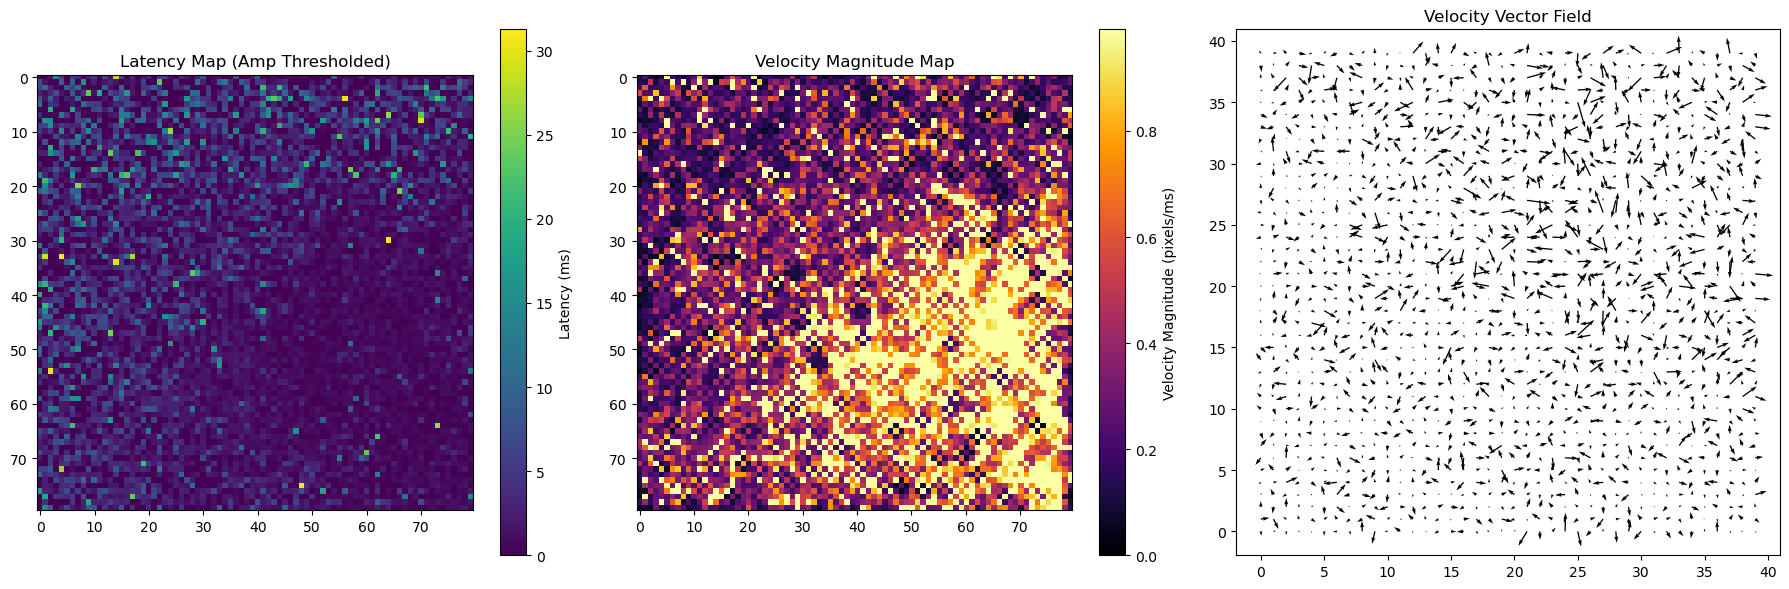

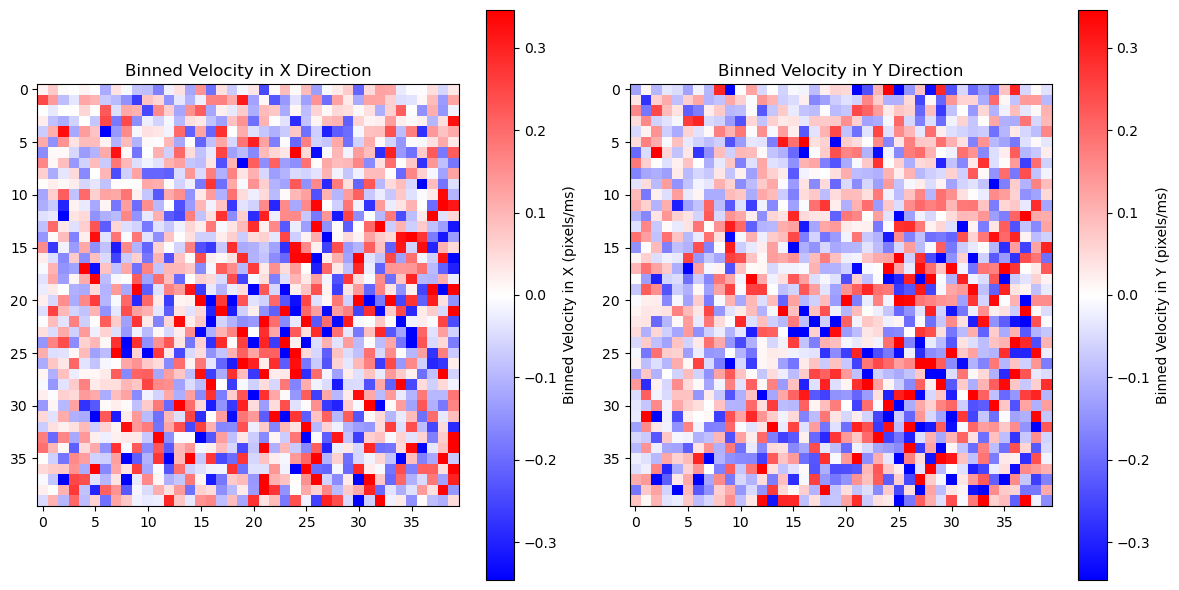

In [26]:
# generalized velocity vector analysis
# from lat_map, thresholded at amp_map's xth percentile
xth_percentile = 0
bin_size = 1

def compute_velocity_maps(lat_map, amp_map, xth_percentile=0, bin_size=1, bin_size_velocities=2):
    # bin amp_map and lat_map
    amp_map_binned = amp_map.reshape(amp_map.shape[0]//bin_size, bin_size, amp_map.shape[1]//bin_size, bin_size).mean(axis=(1,3))
    lat_map_binned = lat_map.reshape(lat_map.shape[0]//bin_size, bin_size, lat_map.shape[1]//bin_size, bin_size).mean(axis=(1,3))
    amp_threshold = np.percentile(amp_map_binned[amp_map_binned > 0], xth_percentile)
    lat_map_masked = np.where(amp_map_binned >= amp_threshold, lat_map_binned, np.nan)

    # compute gradients
    gy, gx = np.gradient(lat_map_binned)

    # compute velocity vectors
    magnitude = np.sqrt(gx**2 + gy**2)

    # epsilon floor: to reduce extreme velocity values due to very small gradient magnitudes (striping)
    eps = np.percentile(magnitude, 20)  # a fixed value in ms/pixel
    eps = max(eps, 0.00001)  # ensure eps is positive to avoid division by zero
    safe_mag = np.maximum(magnitude, eps)
    velocity_magnitude = 1/ safe_mag
    velocity_x = -gx / safe_mag ** 2
    velocity_y = -gy / safe_mag ** 2

    # make quiver plot from binned maps
    binned_velocity_x = velocity_x.reshape(velocity_x.shape[0]//bin_size_velocities, bin_size_velocities, 
                                           velocity_x.shape[1]//bin_size_velocities, bin_size_velocities).mean(axis=(1,3))
    binned_velocity_y = velocity_y.reshape(velocity_y.shape[0]//bin_size_velocities, bin_size_velocities, 
                                           velocity_y.shape[1]//bin_size_velocities, bin_size_velocities).mean(axis=(1,3))
    return lat_map_masked, velocity_magnitude, binned_velocity_x, binned_velocity_y

lat_map_masked, velocity_magnitude, binned_velocity_x, binned_velocity_y = \
    compute_velocity_maps(lat_map, amp_map, xth_percentile=xth_percentile, bin_size=bin_size)

# plot velocity vector field, quiver plot
# also plot gy heatmap and gx heatmap
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(lat_map_masked, cmap='viridis', vmin=0)
plt.colorbar(label='Latency (ms)')
plt.title('Latency Map (Amp Thresholded)')
plt.subplot(1, 3, 2)
plt.imshow(velocity_magnitude, cmap='inferno', vmin=0, vmax=np.percentile(velocity_magnitude, 95))
plt.colorbar(label='Velocity Magnitude (pixels/ms)')
plt.title('Velocity Magnitude Map')
plt.subplot(1, 3, 3)
plt.quiver(binned_velocity_x, binned_velocity_y)
plt.title('Velocity Vector Field')
plt.tight_layout()
plt.savefig(output_fig_dir + f'generalized_velocity_vector_field_{xth_percentile}th_percentile.png')
plt.show()

# plot binned_velocity_x and binned_velocity_y heatmaps
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(binned_velocity_x, cmap='bwr', vmin=-np.percentile(np.abs(binned_velocity_x), 95), vmax=np.percentile(np.abs(binned_velocity_x), 95))
plt.colorbar(label='Binned Velocity in X (pixels/ms)')
plt.title('Binned Velocity in X Direction')
plt.subplot(1, 2, 2)
plt.imshow(binned_velocity_y, cmap='bwr', vmin=-np.percentile(np.abs(binned_velocity_y), 95), vmax=np.percentile(np.abs(binned_velocity_y), 95))
plt.colorbar(label='Binned Velocity in Y (pixels/ms)')
plt.title('Binned Velocity in Y Direction')
plt.tight_layout()
plt.savefig(output_fig_dir + f'gradient_maps_{xth_percentile}th_percentile.png')
plt.show()

In [27]:
# for every lat_map and amp_map in the dataset, compute and save:
#   1) the velocity vector fields, binned velocity x and y maps, and velocity magnitude map
#   2) the clustered latency and amplitude maps using the same k-means clustering approach

def sample_pairwise_neighbor_velocity_similarity(sampled_pixels, velocity_x, velocity_y, similarity_metric='dot_product'):
    similarities = []
    for px_y, px_x in sampled_pixels:
        v1 = np.array([velocity_x[px_y, px_x], velocity_y[px_y, px_x]])
        neighbor_vectors = []
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                if dy == 0 and dx == 0:
                    continue
                n_y = px_y + dy
                n_x = px_x + dx
                if 0 <= n_y < velocity_x.shape[0] and 0 <= n_x < velocity_x.shape[1]:
                    v2 = np.array([velocity_x[n_y, n_x], velocity_y[n_y, n_x]])
                    neighbor_vectors.append(v2)
        for v2 in neighbor_vectors:
            sim = 0
            if similarity_metric == 'cosine_similarity':
                dot_product = np.dot(v1, v2)
                norm_v1 = np.linalg.norm(v1)
                norm_v2 = np.linalg.norm(v2)
                if norm_v1 == 0 or norm_v2 == 0:
                    sim = 0
                else:
                    sim = dot_product / (norm_v1 * norm_v2)
            elif similarity_metric == 'euclidean_distance':
                sim = -np.linalg.norm(v1 - v2)  # negative distance as similarity
            elif similarity_metric == 'dot_product':
                sim = np.dot(v1, v2)
            elif similarity_metric == 'angle_difference':
                # in degrees
                angle1 = np.arctan2(v1[1], v1[0]) * 180 / np.pi
                angle2 = np.arctan2(v2[1], v2[0]) * 180 / np.pi
                sim = np.abs(angle1 - angle2)
                if sim > 180:
                    sim = 360 - sim
            similarities.append(np.abs(sim))
    return similarities

skip_histogram = True
similarity_metric = 'angle_difference'  # 'angle_difference' 'dot_product'  'cosine_similarity' or 'euclidean_distance'
pairwise_neighbor_velocity_similarity = []
scrambled_pairwise_neighbor_velocity_similarity = []
low_latency_pairwise_neighbor_velocity_similarity = []
mag_percentile = 0
skip_plots = True
for date in ppr_df['Date'].unique():
    if skip_histogram:
        continue
    date_df = ppr_df[ppr_df['Date'] == date]
    for slic in date_df['Slice'].unique():
        slice_df = date_df[date_df['Slice'] == slic]
        for location in slice_df['Location'].unique():
            location_df = slice_df[slice_df['Location'] == location]
            for recording in location_df['Recording'].unique():
                recording_df = location_df[location_df['Recording'] == recording]

                # find the corresponding lat_map and amp_map files
                lat_map_file = recording_df.iloc[0]['latency_array']
                amp_map_file = recording_df.iloc[0]['amp_array']
                stim_time = recording_df.iloc[0]['stim_time']
                lat_map = read_array_file(lat_map_file) - stim_time
                amp_map = read_array_file(amp_map_file)

                # velocity vector analysis using compute_velocity_maps
                lat_map_masked, velocity_magnitude, velocity_x, velocity_y = \
                    compute_velocity_maps(lat_map, amp_map, xth_percentile=0, bin_size=1)
                
                # randomly sample NUM_SAMPLES pixels in the 80x80
                sampled_pixels = []
                num_samples = 10
                attempts = 1000
                mag_cutoff = np.percentile(velocity_magnitude, mag_percentile)
                while len(sampled_pixels) < num_samples and attempts > 0:
                    px_x = np.random.randint(0, velocity_x.shape[1])
                    px_y = np.random.randint(0, velocity_x.shape[0])
                    # only keep if in top 5%ile of velocity magnitude
                    if velocity_magnitude[px_y, px_x] >= mag_cutoff:
                        sampled_pixels.append((px_y, px_x))
                    attempts -= 1

                low_latency_pixels = []
                attempts = 1000
                # sample NUM_SAMPLES pixels with latency lower than their neighbors
                while len(low_latency_pixels) < num_samples and attempts > 0:
                    px_x = np.random.randint(0, velocity_x.shape[1]-1)
                    px_y = np.random.randint(0, velocity_x.shape[0]-1)
                    # only keep if in top 5%ile of velocity magnitude
                    if velocity_magnitude[px_y, px_x] >= mag_cutoff:
                        sampled_pixels.append((px_y, px_x))
                    pixel_latency = lat_map_masked[px_y, px_x]
                    if np.isnan(pixel_latency) or pixel_latency <= 0:
                        attempts -= 1
                        continue
                    neighbor_latencies = []
                    for dy in [-1, 0, 1]:
                        for dx in [-1, 0, 1]:
                            if dy == 0 and dx == 0:
                                continue
                            n_y = px_y + dy
                            n_x = px_x + dx
                            neighbor_latency = lat_map_masked[n_y, n_x]
                            if not np.isnan(neighbor_latency) and neighbor_latency > 0:
                                neighbor_latencies.append(neighbor_latency)
                    if all(pixel_latency < nl for nl in neighbor_latencies):
                        low_latency_pixels.append((px_y, px_x))
                    attempts -= 1
                
                # for each pixel, find its 8 neighbors and compute cosine similarity of velocity vectors
                pairwise_neighbor_velocity_similarity.extend(
                    sample_pairwise_neighbor_velocity_similarity(sampled_pixels, velocity_x, velocity_y, similarity_metric)
                )
                low_latency_pairwise_neighbor_velocity_similarity.extend(
                    sample_pairwise_neighbor_velocity_similarity(low_latency_pixels, velocity_x, velocity_y, similarity_metric)
                )
                # scramble velocity_x and velocity_y maps according to ONE random permutation
                permutation = np.random.permutation(velocity_x.size)
                scrambled_velocity_x = velocity_x.flatten()[permutation].reshape(velocity_x.shape)
                scrambled_velocity_y = velocity_y.flatten()[permutation].reshape(velocity_y.shape)
                scrambled_magnitude = np.sqrt(scrambled_velocity_x**2 + scrambled_velocity_y**2)
                scrambled_mag_cutoff = np.percentile(scrambled_magnitude, 80)
                # resample pixels in top 5%ile of scrambled velocity magnitude
                sampled_pixels = []
                attempts = 1000
                while len(sampled_pixels) < num_samples and attempts > 0:
                    px_x = np.random.randint(0, scrambled_velocity_x.shape[1])
                    px_y = np.random.randint(0, scrambled_velocity_x.shape[0])
                    if scrambled_magnitude[px_y, px_x] >= scrambled_mag_cutoff:
                        sampled_pixels.append((px_y, px_x))
                    attempts -= 1
                scrambled_pairwise_neighbor_velocity_similarity.extend(
                    sample_pairwise_neighbor_velocity_similarity(sampled_pixels, scrambled_velocity_x, scrambled_velocity_y, similarity_metric)
                )
                
                # plot and save velocity maps
                if skip_plots:
                    continue
                plt.figure(figsize=(12, 9))
                plt.subplot(2, 2, 1)
                plt.imshow(lat_map_masked, cmap='viridis', vmin=0)
                plt.colorbar(label='Latency (ms)')
                plt.title('Latency Map (Amp Thresholded)')
                plt.subplot(2, 2, 2)
                plt.imshow(velocity_magnitude, cmap='inferno', vmin=0, vmax=np.percentile(velocity_magnitude, 95))
                plt.colorbar(label='Velocity Magnitude (pixels/ms)')
                plt.title('Velocity Magnitude Map')
                plt.subplot(2, 2, 3)
                plt.imshow(velocity_x, cmap='bwr', vmin=-np.percentile(np.abs(velocity_x), 95), vmax=np.percentile(np.abs(velocity_x), 95))
                plt.title('Velocity in X Direction')
                plt.colorbar(label='Velocity X (pixels/ms)')
                plt.subplot(2, 2, 4)
                plt.imshow(velocity_y, cmap='bwr', vmin=-np.percentile(np.abs(velocity_y), 95), vmax=np.percentile(np.abs(velocity_y), 95))
                plt.title('Velocity in Y Direction')
                plt.colorbar(label='Velocity Y (pixels/ms)')
                plt.tight_layout()
                plt.savefig(output_fig_dir + f'velocity_maps_{date.replace("/", "")}_{slic}_{location}_{recording}.png')
                plt.close()

print(len(pairwise_neighbor_velocity_similarity), len(scrambled_pairwise_neighbor_velocity_similarity))
  

0 0


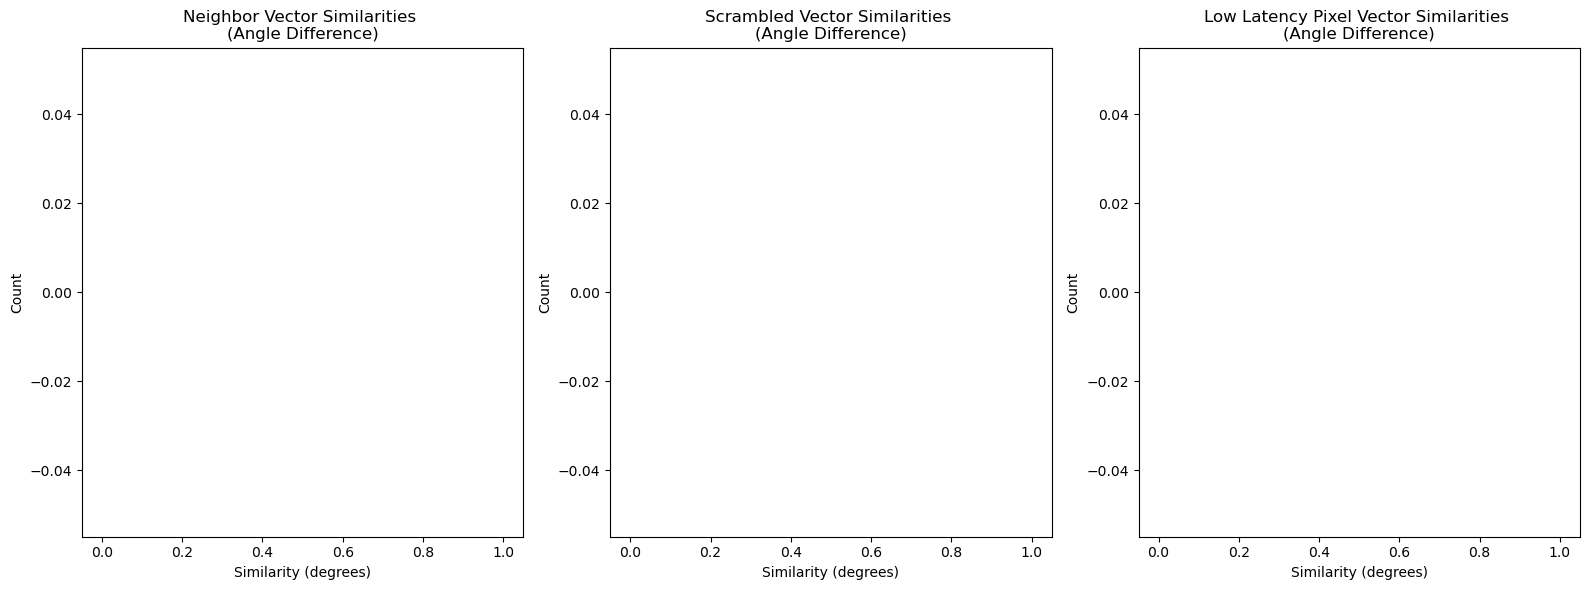

In [28]:
# now plot histogram of pairwise neighbor velocity similarities and scrambled version
if skip_histogram:
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 3, 1)
    plt.hist(pairwise_neighbor_velocity_similarity, bins=500, color='blue', alpha=0.7)
    plt.title('Neighbor Vector Similarities \n(' + similarity_metric.replace('_', ' ').title() + ')')
    plt.xlabel('Similarity' + (' (degrees)' if similarity_metric == 'angle_difference' else ''))
    plt.ylabel('Count')
    #plt.xlim(0, 0.1)
    #y_limits = plt.ylim()  # get y limits to use for right plot
    plt.subplot(1, 3, 2)
    plt.hist(scrambled_pairwise_neighbor_velocity_similarity, bins=500, color='red', alpha=0.7)
    plt.title('Scrambled Vector Similarities \n(' + similarity_metric.replace('_', ' ').title() + ')')
    plt.xlabel('Similarity' + (' (degrees)' if similarity_metric == 'angle_difference' else ''))
    plt.ylabel('Count')
    #plt.xlim(0, 0.1)
    # same y lim as left plot
    #plt.ylim(y_limits)
    plt.subplot(1, 3, 3)
    plt.hist(low_latency_pairwise_neighbor_velocity_similarity, bins=500, color='green', alpha=0.7)
    plt.title('Low Latency Pixel Vector Similarities \n(' + similarity_metric.replace('_', ' ').title() + ')')
    plt.xlabel('Similarity' + (' (degrees)' if similarity_metric == 'angle_difference' else ''))
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig(output_fig_dir + f'pairwise_neighbor_velocity_similarity_histograms_{similarity_metric}.png')
    plt.show()

In [29]:
# from example, within high-amplitude areas, find single pixels where latency is lower than surrounding pixels
amplitude_percentile_threshold = 50
example_data_dir = 'C:/Users/jjudge3/Desktop/Data/PV-PPR/ai35hVOS_PVCre/'
example_lat_map_file = example_data_dir + '2023-09-11/_07_01_01_latency_array_analysis07_01_01_rois_layer_L4_pulse1.dat'
example_amp_map_file = example_data_dir + '2023-09-11/_07_01_01_amp_array_analysis07_01_01_rois_layer_L4_pulse1.dat'
example_stim_time = 49.25082754054949
lat_map = read_array_file(example_lat_map_file) - example_stim_time
amp_map = read_array_file(example_amp_map_file)
# mask out latencies where amp_map is less than its xth percentile
amp_threshold = np.percentile(amp_map[amp_map > 0], amplitude_percentile_threshold)

def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

def outline_region(pixels_or_mask, ax=None, shape=None, extent=None, origin='lower',
                   color=(1,0,0,0.5), linewidth=3):
    """
    Outline a set of pixels on an existing Matplotlib axes.

    Parameters
    - pixels_or_mask: iterable of (row, col) pairs OR a 2D boolean/0-1 array (mask).
                      Row = y, Col = x (0-based).
    - ax: matplotlib Axes to draw on (defaults to plt.gca()).
    - shape: (nrows, ncols) to define grid size if passing pixel list (optional).
             If None, inferred from pixel coordinates.
    - extent: (x0, y0, x1, y1) maps pixel-grid coords to axis coords (optional).
              If None, coordinates are left in pixel units.
    - origin: 'lower' (default) or 'upper' — matches imshow origin behavior.
    - color, linewidth: plotting style.

    Returns: the Axes instance used (or None if nothing drawn)
    """
    if ax is None:
        ax = plt.gca()

    # Accept mask array directly
    if isinstance(pixels_or_mask, (np.ndarray, list)) and getattr(pixels_or_mask, 'ndim', None) == 2:
        mapimg = np.asarray(pixels_or_mask).astype(bool)
    else:
        pixels = np.asarray(list(pixels_or_mask), dtype=int)
        if pixels.size == 0:
            return ax
        if shape is None:
            nrows = pixels[:,0].max() + 1
            ncols = pixels[:,1].max() + 1
            shape = (nrows, ncols)
        mapimg = np.zeros(shape, dtype=bool)
        rr, cc = pixels[:,0], pixels[:,1]
        valid = (rr >= 0) & (rr < shape[0]) & (cc >= 0) & (cc < shape[1])
        mapimg[rr[valid], cc[valid]] = True

    # detect boundary segments (following your original approach)
    ver_seg = np.where(mapimg[:,1:] != mapimg[:,:-1])
    hor_seg = np.where(mapimg[1:,:] != mapimg[:-1,:])

    pts = []
    for p in zip(*hor_seg):
        pts.append((p[1], p[0]+1))
        pts.append((p[1]+1, p[0]+1))
        pts.append((np.nan, np.nan))
    for p in zip(*ver_seg):
        pts.append((p[1]+1, p[0]))
        pts.append((p[1]+1, p[0]+1))
        pts.append((np.nan, np.nan))

    if not pts:
        return ax

    segments = np.array(pts, dtype=float)

    # handle origin flip to match imshow(origin='upper')
    if origin == 'upper':
        segments[:,1] = mapimg.shape[0] - segments[:,1]

    # apply extent mapping if provided: (x0, y0, x1, y1)
    if extent is not None:
        x0, y0, x1, y1 = extent
        segments[:,0] = x0 + (x1 - x0) * segments[:,0] / mapimg.shape[1]
        segments[:,1] = y0 + (y1 - y0) * segments[:,1] / mapimg.shape[0]

    ax.plot( segments[:,1], segments[:,0], color=color, linewidth=linewidth)
    return ax

def find_contiguous_subregion_of_cosine_similarity(angle_similarity_map, angle_threshold=30):
    ''' if the angle difference between velocity vectors is less than angle_threshold (in degrees),
    group them into contiguous subregions using flood fill algorithm'''
    visited = np.zeros_like(angle_similarity_map, dtype=bool)
    subregions = []
    for y in range(angle_similarity_map.shape[0]):
        for x in range(angle_similarity_map.shape[1]):
            if visited[y, x]:
                continue
            angle = angle_similarity_map[y, x]
            if np.isnan(angle):
                continue
            new_region = []
            queue = [(x, y)]
            while queue:
                px_x, px_y = queue.pop(0)
                if visited[px_y, px_x]:
                    continue
                visited[px_y, px_x] = True
                new_region.append((px_x, px_y))
                # check neighbors
                for dy in [-1, 0, 1]:
                    for dx in [-1, 0, 1]:
                        if dy == 0 and dx == 0:
                            continue
                        n_x = px_x + dx
                        n_y = px_y + dy
                        if 0 <= n_x < angle_similarity_map.shape[1] and 0 <= n_y < angle_similarity_map.shape[0]:
                            neighbor_angle = angle_similarity_map[n_y, n_x]
                            if not visited[n_y, n_x] and not np.isnan(neighbor_angle):
                                angle_diff = np.abs(angle - neighbor_angle) 
                                if angle_diff > 180:
                                    angle_diff = 360 - angle_diff
                                if angle_diff <= angle_threshold:
                                    queue.append((n_x, n_y))
            if len(new_region) > 0:
                subregions.append(new_region)
    return subregions

def compute_low_latency_and_vector_sim_subregions(output_file_png, lat_map_masked, velocity_x, velocity_y, 
                                                  amp_threshold_percentile=50, similarity_metric='dot_product', 
                                                  show_plots=False, close_plots=False):
    # find pixels in the masked lat_map where the latency is less than at least 5 of its 8 neighbors
    amp_threshold = np.percentile(amp_map[amp_map > 0], amp_threshold_percentile)
    low_latency_pixels = []
    for y in range(1, lat_map_masked.shape[0]-1):
        for x in range(1, lat_map_masked.shape[1]-1):
            center_latency = lat_map_masked[y, x]
            if np.isnan(center_latency) or center_latency <= 0.2:
                continue
            neighbor_latencies = [
                lat_map_masked[y-1, x-1], lat_map_masked[y-1, x], lat_map_masked[y-1, x+1],
                lat_map_masked[y, x-1],                     lat_map_masked[y, x+1],
                lat_map_masked[y+1, x-1], lat_map_masked[y+1, x], lat_map_masked[y+1, x+1]
            ]
            # allow at most 3 neighbors to be nan
            nan_count = sum(1 for nl in neighbor_latencies if np.isnan(nl))
            if nan_count > 3:
                continue
            if center_latency < min(nl for nl in neighbor_latencies):
                low_latency_pixels.append((x, y))

    low_latency_neighbor_similarities = []
    low_latency_neighbor_similarities.extend(
                        sample_pairwise_neighbor_velocity_similarity(low_latency_pixels, velocity_x, velocity_y, similarity_metric)
                    )
    control_random_pixels = []
    attempts = 10000
    while len(control_random_pixels) < len(low_latency_pixels) and attempts > 0:
        attempts -= 1
        rand_x = np.random.randint(1, lat_map_masked.shape[1]-1)
        rand_y = np.random.randint(1, lat_map_masked.shape[0]-1)
        if np.isnan(lat_map_masked[rand_y, rand_x]):
            continue
        if (rand_x, rand_y) not in control_random_pixels:
            control_random_pixels.append((rand_x, rand_y))
            break
    random_neighbor_similarities = []
    random_neighbor_similarities.extend(
                        sample_pairwise_neighbor_velocity_similarity(control_random_pixels, velocity_x, velocity_y, similarity_metric)
                    )

    # compare latencies of low_latency_pixels to their neighbors
    latencies_low = [lat_map_masked[y, x] for x, y in low_latency_pixels]
    latencies_neighbor = []
    for x, y in low_latency_pixels:
        neighbor_latencies = []
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                if dy == 0 and dx == 0:
                    continue
                n_y = y + dy
                n_x = x + dx
                neighbor_latency = lat_map_masked[n_y, n_x]
                if not np.isnan(neighbor_latency):
                    neighbor_latencies.append(neighbor_latency)
        latencies_neighbor.append(np.mean(neighbor_latencies))

    # build vector angle map
    velocity_magnitude = np.sqrt(velocity_x**2 + velocity_y**2)
    angle_map = np.zeros_like(velocity_x)  # angle map will be the angle of the velocity vector at each pixel
    angle_map[:] = np.nan
    for y in range(velocity_x.shape[0]):
        for x in range(velocity_x.shape[1]):
            if not np.isnan(velocity_x[y, x]) and not np.isnan(velocity_y[y, x]) \
                and amp_map[y, x] > amp_threshold \
                    and velocity_magnitude[y, x] < 10000 \
                        and velocity_magnitude[y, x] > 0.1:
                angle_map[y, x] = np.arctan2(velocity_y[y, x], velocity_x[y, x]) * 180 / np.pi  # in degrees

    subregions = find_contiguous_subregion_of_cosine_similarity(angle_map, angle_threshold=30)  # degrees
    # keep only subregions larger than x pixels
    min_subregion_size = 4
    subregions = [sr for sr in subregions if len(sr) >= min_subregion_size]

    # show lat_map_masked
    plt.figure(figsize=(27, 27))
    plt.subplot(3, 3, 1)
    plt.imshow(lat_map_masked, cmap='viridis', vmin=0)
    plt.colorbar(label='Latency (ms)')
    for x, y in low_latency_pixels:
        highlight_cell(x, y, color='white', linewidth=0.5)
    plt.title('Latency Map (Amp Thresholded)')
    plt.subplot(3, 3, 2)
    plt.imshow(amp_map, cmap='inferno')
    plt.colorbar(label='Amplitude (ΔF/F)')
    plt.title('Amplitude Map')
    plt.tight_layout()
    for x, y in low_latency_pixels:
        highlight_cell(x, y, color='white', linewidth=0.5)
    plt.subplot(3, 3, 3)
    velocity_magnitude[velocity_magnitude > 10000] = 0
    plt.imshow(velocity_magnitude, cmap='inferno', vmin=0.5, vmax=np.percentile(velocity_magnitude, 95))
    plt.colorbar(label='Velocity Magnitude (pixels/ms)')
    plt.title('Velocity Magnitude Map')
    plt.tight_layout()
    for x, y in low_latency_pixels:
        highlight_cell(x, y, color='black', linewidth=0.5)
    plt.subplot(3, 3, 4)
    plt.imshow(velocity_x, cmap='bwr', vmin=-np.percentile(np.abs(velocity_x), 95), vmax=np.percentile(np.abs(velocity_x), 95))
    plt.title('Velocity in X Direction')
    plt.colorbar(label='Velocity X (pixels/ms)')
    plt.tight_layout()
    for x, y in low_latency_pixels:
        highlight_cell(x, y, color='black', linewidth=1)
    plt.subplot(3, 3, 5)
    plt.imshow(velocity_y, cmap='bwr', vmin=-np.percentile(np.abs(velocity_y), 95), vmax=np.percentile(np.abs(velocity_y), 95))
    plt.title('Velocity in Y Direction')
    plt.colorbar(label='Velocity Y (pixels/ms)')
    plt.tight_layout()
    for x, y in low_latency_pixels:
        highlight_cell(x, y, color='black', linewidth=1)

    plt.subplot(3, 3, 6)
    # barplot and scatter of latencies_low vs latencies_neighbor's latencies
    labels = ['Low Latency Pixels', 'Neighboring Pixels']
    x = np.arange(len(labels))
    means = [np.mean(latencies_low), np.mean(latencies_neighbor)]
    sems = [np.std(latencies_low)/np.sqrt(len(latencies_low)), np.std(latencies_neighbor)/np.sqrt(len(latencies_neighbor))]
    plt.bar(x, means, yerr=sems, capsize=5, color=['blue', 'orange'], alpha=0.6, width=0.5, edgecolor='black')
    x_jitter = np.random.normal(0, 0.05, size=len(latencies_low))
    plt.scatter(np.zeros(len(latencies_low)) + 0.1 * (np.random.rand(len(latencies_low)) - 0.5) + x_jitter, latencies_low, color='blue', alpha=0.6)
    x_jitter = np.random.normal(0, 0.05, size=len(latencies_neighbor))
    plt.scatter(np.ones(len(latencies_neighbor)) + 0.1 * (np.random.rand(len(latencies_neighbor)) - 0.5) + x_jitter, latencies_neighbor, color='orange', alpha=0.6)
    plt.xticks(x, labels)
    plt.ylabel('Latency (ms)')

    plt.subplot(3, 3, 7)
    plt.imshow(angle_map, cmap='hsv')
    plt.colorbar(label='Angle (radians)')
    plt.title('Angle Map')
    for subregion in subregions:
        outline_region(subregion, ax=plt.gca(), color='black', linewidth=2)

    plt.subplot(3, 3, 8)
    blank = np.zeros_like(angle_map)
    blank[:] = np.nan
    # shade each subregion
    for i, subregion in enumerate(subregions):
        id = np.random.randint(0, len(subregions))
        for x, y in subregion:
            blank[y, x] = angle_map[y, x]
    for x, y in low_latency_pixels:
        highlight_cell(x, y, color='black', linewidth=1)
    plt.imshow(blank, cmap='hsv')
    plt.colorbar(label='Velocity Angle')
    plt.title('Subregions of Similar Velocity Angles')
    plt.savefig(output_file_png)
    if show_plots:
        plt.show()
    if close_plots:
        plt.close()

    # garbage collection to free memory
    del lat_map_masked, velocity_x, velocity_y, angle_map, velocity_magnitude, blank, latencies_low, latencies_neighbor
    gc.collect()

    return low_latency_pixels, subregions

def run_all_clustering_methods(lat_map, amp_map, amp_percentile_threshold=50, max_roi_width=6, output_keyword="", show_plots=True):
    # generalized velocity vector analysis
        # from lat_map, thresholded at amp_map's xth percentile
    lat_map_masked, velocity_magnitude, velocity_x, velocity_y = \
        compute_velocity_maps(lat_map, amp_map, xth_percentile=amp_percentile_threshold, bin_size=1, bin_size_velocities=1)
    low_latency_pixels, subregions = compute_low_latency_and_vector_sim_subregions(
        output_fig_dir + f'low_latency_and_vector_similarity_subregions_{output_keyword}.png',
        lat_map_masked, velocity_x, velocity_y, amp_threshold_percentile=amp_percentile_threshold, 
        similarity_metric='angle_difference', show_plots=show_plots, close_plots=True
    )

    roi_clusters, n_rois_dict = cluster_rois_by_latency_and_amplitude(output_fig_dir, output_keyword, lat_map_masked, 
                                                                      amp_map, max_roi_width=max_roi_width, show_plots=show_plots,
                                                                      verbose=False, create_plots=False)
    
    return roi_clusters, n_rois_dict, low_latency_pixels, subregions

def do_rois_overlap(roi1, roi2):
    # Check if two ROIs overlap
    for px1 in roi1:
        for px2 in roi2:
            if px1[0] == px2[0] and px1[1] == px2[1]:
                return True
    return False

def count_overlap_all_ways(subregions, low_latency_pixels, composite_clustered_rois):

    overlap_counts = {
        'subregions_vs_low_latency': 0,
        'subregions_vs_composite_clustered': 0,
        'low_latency_vs_composite_clustered': 0,
        'all_ways': 0
    }
    for subregion in subregions:
        # check overlap with low_latency_pixels
        for px in low_latency_pixels:
            ll_roi = [px]
            if do_rois_overlap(subregion, ll_roi):
                overlap_counts['subregions_vs_low_latency'] += 1

        # check overlap with composite_clustered_rois
        for roi in composite_clustered_rois:
            if do_rois_overlap(subregion, roi):
                overlap_counts['subregions_vs_composite_clustered'] += 1
            for px in low_latency_pixels:
                ll_roi = [px]
                if do_rois_overlap(subregion, ll_roi):
                    overlap_counts['all_ways'] += 1

    return overlap_counts

In [ ]:
n_to_show = 0
n_roi_stats = {}
# load all the keys to skip from the csv if it exists
if os.path.exists(output_fig_dir + 'n_roi_stats_summary.csv'):
    existing_df = pd.read_csv(output_fig_dir + 'n_roi_stats_summary.csv', index_col=0)
    n_roi_keys_to_skip = existing_df.index.tolist()
else:
    n_roi_keys_to_skip = []

for date in ppr_df['Date'].unique():
    date_df = ppr_df[ppr_df['Date'] == date]
    for slic in date_df['Slice'].unique():
        slice_df = date_df[date_df['Slice'] == slic]
        for location in slice_df['Location'].unique():
            location_df = slice_df[slice_df['Location'] == location]
            for recording in location_df['Recording'].unique():
                recording_df = location_df[location_df['Recording'] == recording]

                n_roi_stats_key = f'{date}_{slic}_{location}_{recording}'
                if n_roi_stats_key in n_roi_keys_to_skip:
                    continue

                # find the corresponding lat_map and amp_map files
                lat_map_file = recording_df.iloc[0]['latency_array']
                amp_map_file = recording_df.iloc[0]['amp_array']
                stim_time = recording_df.iloc[0]['stim_time']
                lat_map = read_array_file(lat_map_file) - stim_time
                amp_map = read_array_file(amp_map_file)

                roi_clusters, n_rois_dict, low_latency_pixels, subregions = run_all_clustering_methods(
                    lat_map, amp_map, amp_percentile_threshold=80, max_roi_width=3,
                    output_keyword=f'{date.replace("/", "")}_{slic}_{location}_{recording}', show_plots=(n_to_show > 0))
                n_to_show -= 1

                # count number of low_latency_pixels and subregions
                n_low_latency_pixels = len(low_latency_pixels)
                n_subregions = len(subregions)

                # keep n_roi stats
                n_roi_stats[n_roi_stats_key] = {
                    'n_low_latency_pixels': n_low_latency_pixels,
                    'n_subregions': n_subregions,
                }
                for k, v in n_rois_dict.items():
                    n_roi_stats[n_roi_stats_key][k] = v

                # count overlaps
                overlap_counts = count_overlap_all_ways(subregions, low_latency_pixels, roi_clusters)
                n_roi_stats[n_roi_stats_key].update(overlap_counts)

                # garbage collect
                del lat_map, amp_map, subregions, low_latency_pixels, roi_clusters
                gc.collect()

                # add n_roi_stats_key to n_roi_keys_to_skip to avoid re-processing
                n_roi_keys_to_skip.append(n_roi_stats_key)

        # save slice stats to file
        n_roi_stats_df = pd.DataFrame.from_dict(n_roi_stats, orient='index')
        if not os.path.exists(output_fig_dir + 'n_roi_stats_summary.csv'):
            n_roi_stats_df.to_csv(output_fig_dir + 'n_roi_stats_summary.csv')
        else: 
            # append to existing csv
            existing_df = pd.read_csv(output_fig_dir + 'n_roi_stats_summary.csv', index_col=0)
            combined_df = pd.concat([existing_df, n_roi_stats_df])
            # remove duplicates
            combined_df = combined_df[~combined_df.index.duplicated(keep='last')]
            # overwrite csv
            combined_df.to_csv(output_fig_dir + 'n_roi_stats_summary.csv')
        # print current n_roi_keys_to_skip
        print(f'Processed date {date} slice {slic}, updated n_roi_keys_to_skip length: {len(n_roi_keys_to_skip)}')



c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scala

Processed date 22-9-2 slice 1, updated n_roi_keys_to_skip length: 9


c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scala

Processed date 22-9-2 slice 2, updated n_roi_keys_to_skip length: 18


c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scala

Processed date 22-9-2 slice 3, updated n_roi_keys_to_skip length: 27


c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scala

Processed date 22-9-2 slice 4, updated n_roi_keys_to_skip length: 36


c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scala

Processed date 22-9-2 slice 5, updated n_roi_keys_to_skip length: 45


c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scala

Processed date 22-9-2 slice 6, updated n_roi_keys_to_skip length: 54


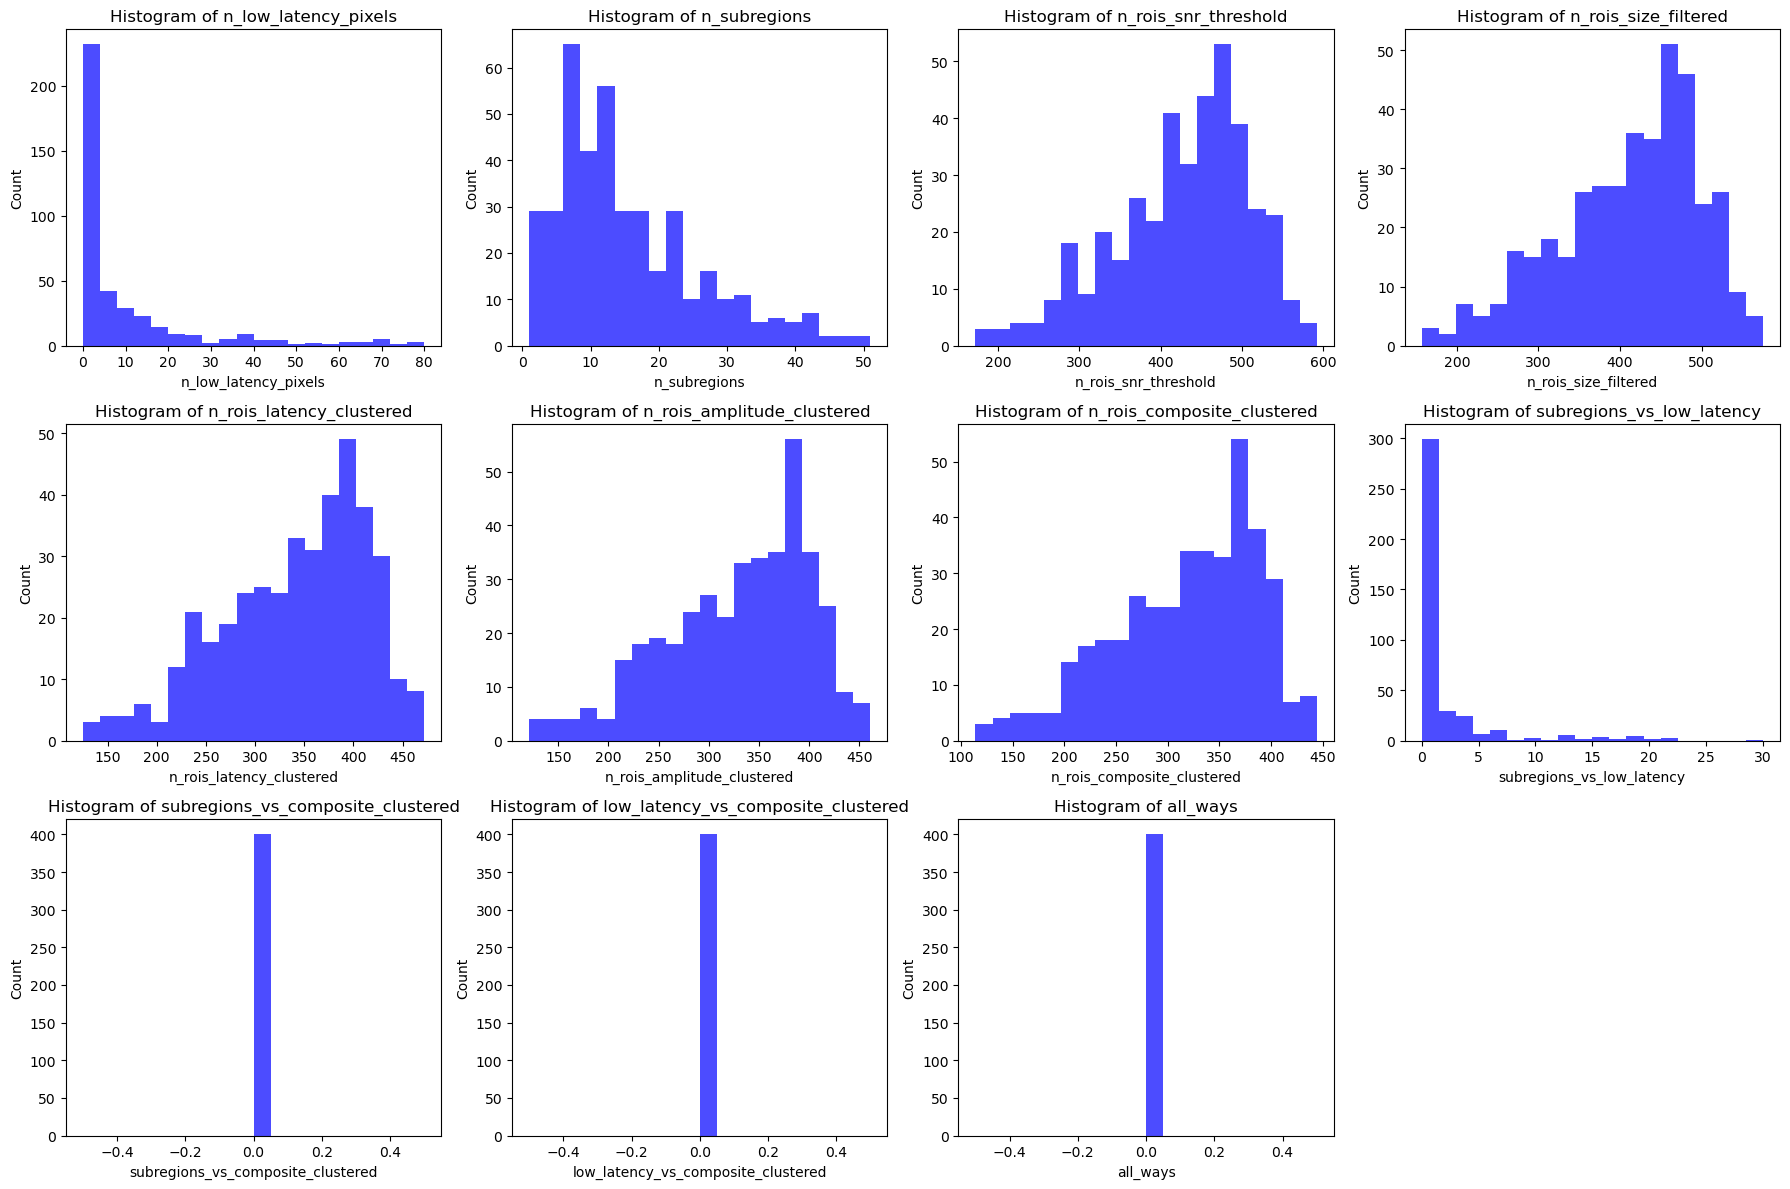

In [ ]:
# save n_roi_stats to csv
n_roi_stats_df = pd.DataFrame.from_dict(n_roi_stats, orient='index')
if not os.path.exists(output_fig_dir + 'n_roi_stats_summary.csv'):
    n_roi_stats_df.to_csv(output_fig_dir + 'n_roi_stats_summary.csv')
else: 
    # append to existing csv
    existing_df = pd.read_csv(output_fig_dir + 'n_roi_stats_summary.csv', index_col=0)
    combined_df = pd.concat([existing_df, n_roi_stats_df])
    # remove duplicates
    combined_df = combined_df[~combined_df.index.duplicated(keep='last')]
    # overwrite csv
    combined_df.to_csv(output_fig_dir + 'n_roi_stats_summary.csv')
    
# show summary histograms of n_roi_stats_df columns
plt.figure(figsize=(18, 12))
for i, column in enumerate(n_roi_stats_df.columns):
    plt.subplot(3, 4, i+1)
    plt.hist(n_roi_stats_df[column], bins=20, color='blue', alpha=0.7)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
plt.tight_layout()
plt.savefig(output_fig_dir + 'n_roi_stats_histograms.png')
plt.show()
plt.close()

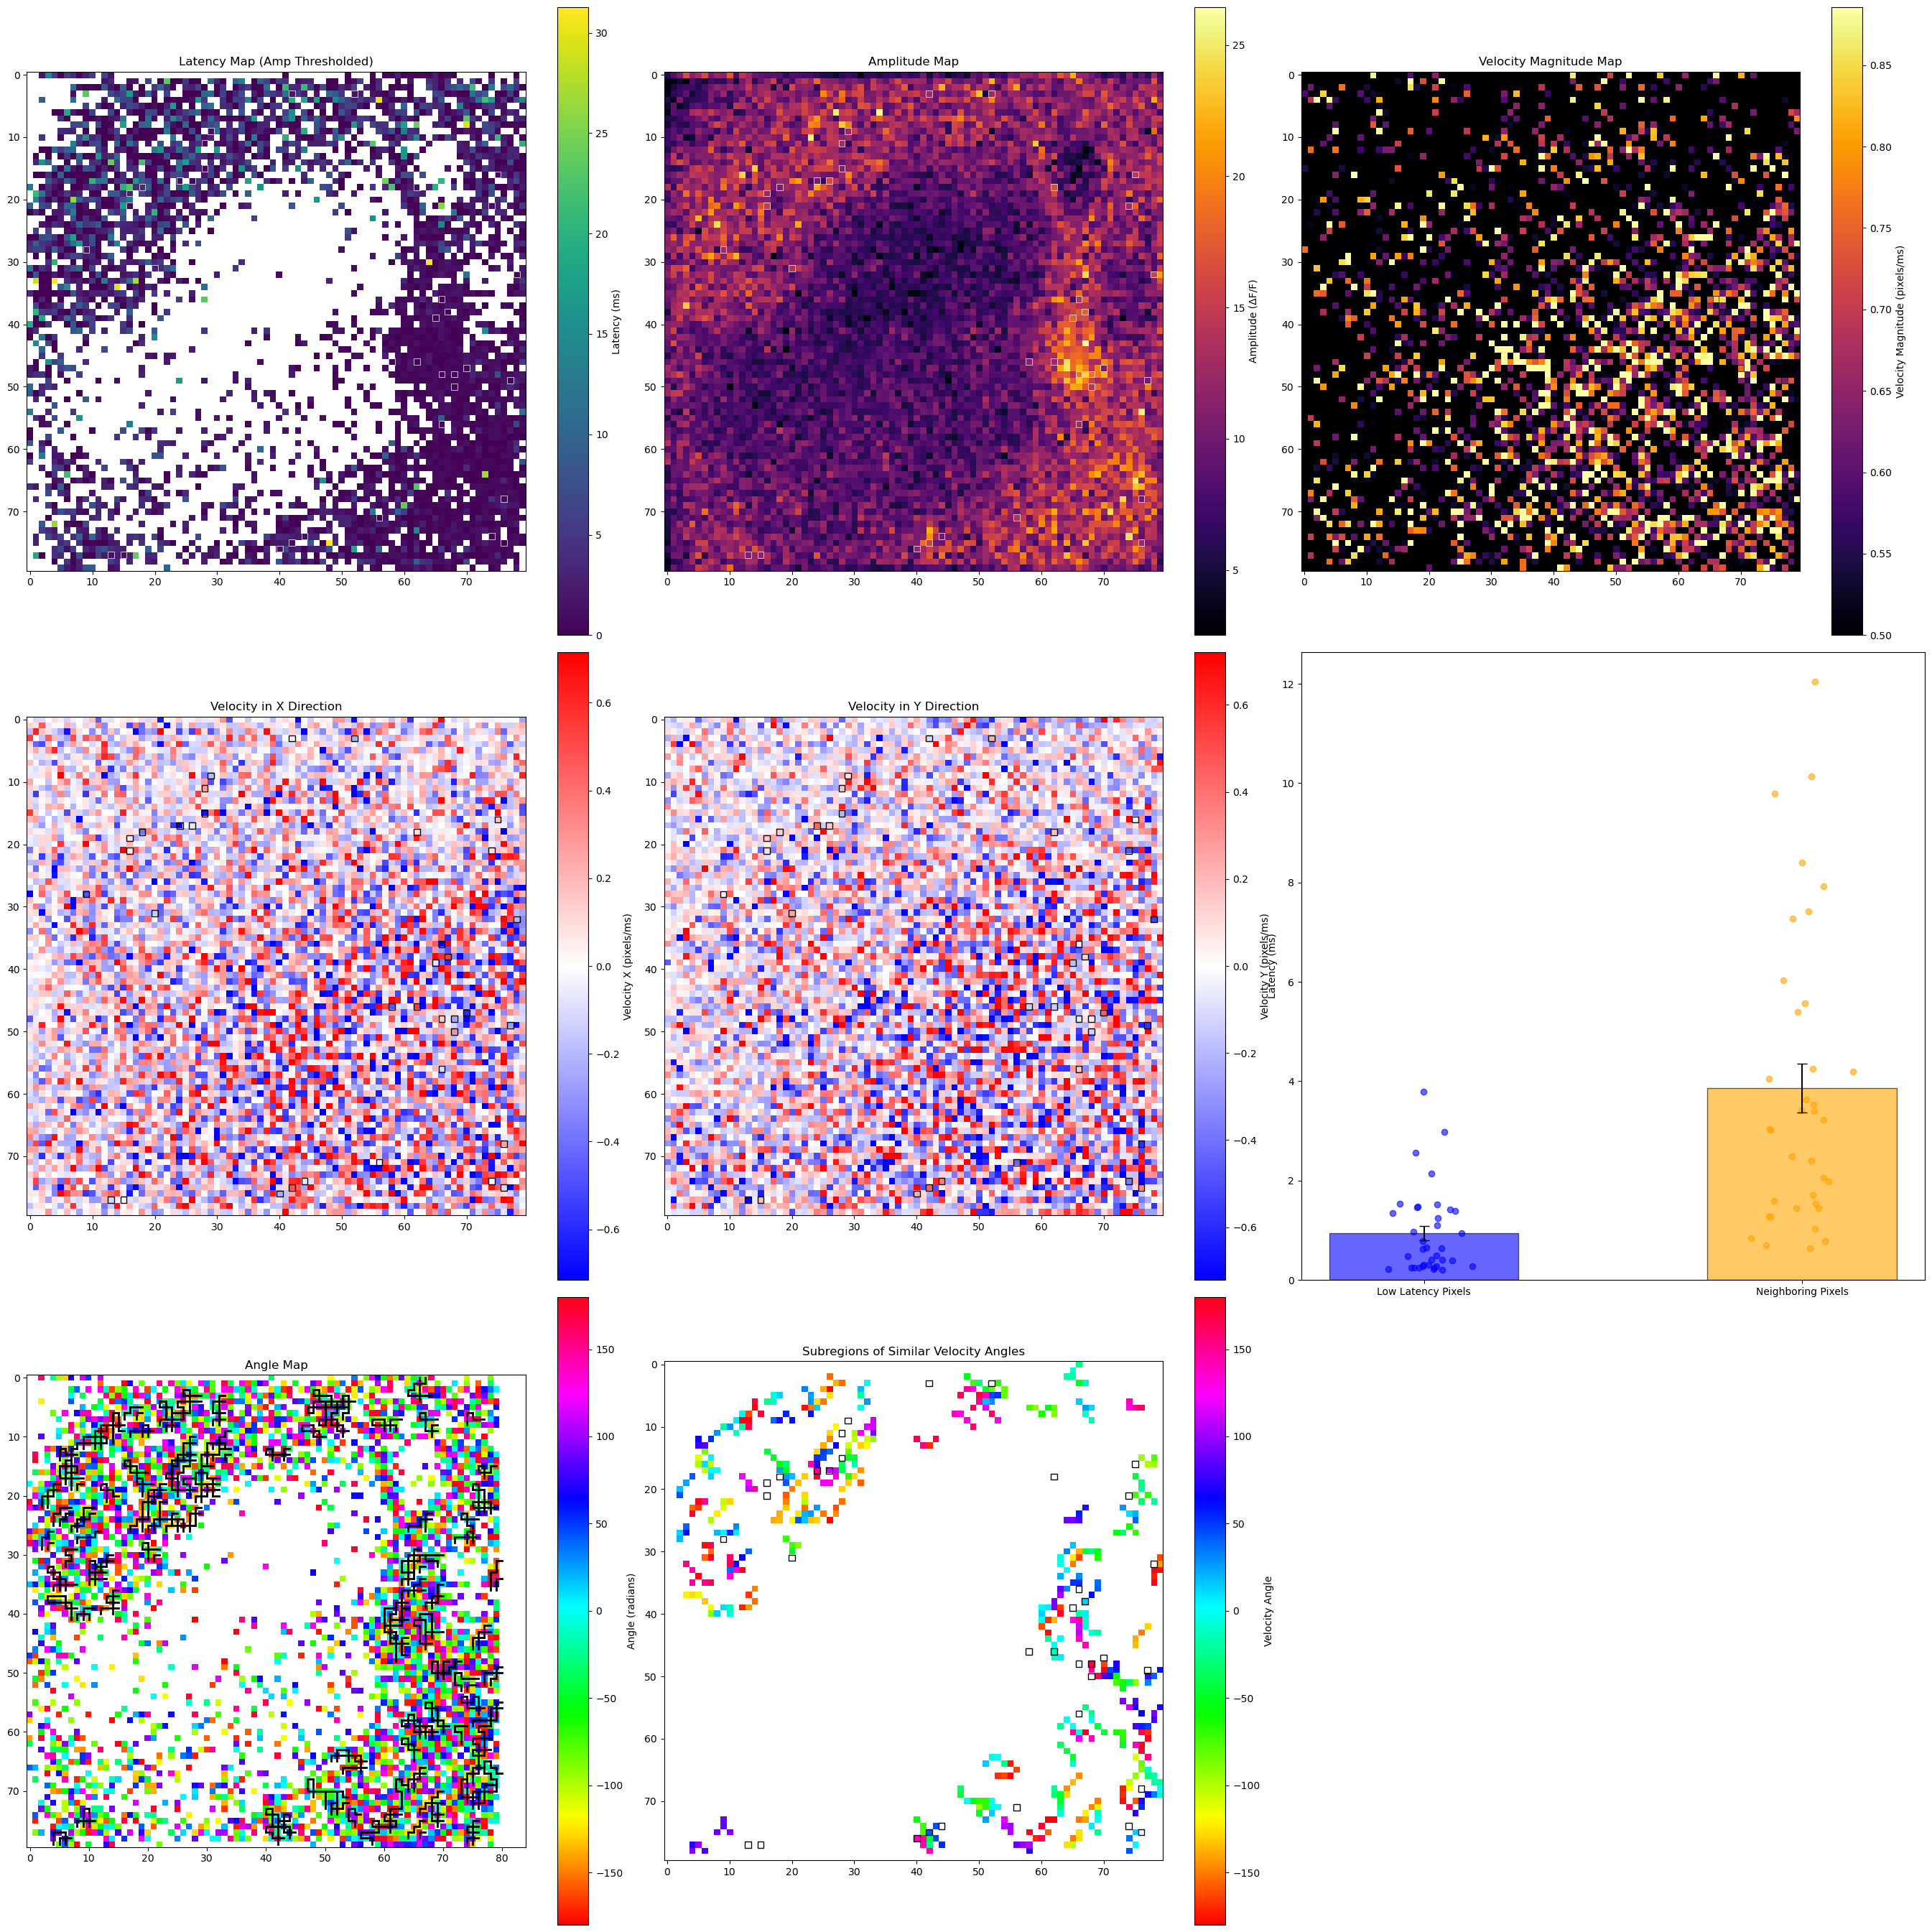

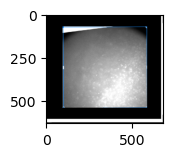

In [ ]:
# mCherry example 2/20/24, 02_01_01
use_mCherry_example = True
if use_mCherry_example:
    example_data_dir = 'C:/Users/jjudge3/Desktop/Data/PV-PPR/mCherry-PV/'
    example_lat_map_file = example_data_dir + '02-20-24/zda/_02_01_01_latency_array_.dat'
    example_amp_map_file = example_data_dir + '02-20-24/zda/_02_01_01_amp_array_.dat'
    example_stim_time = 49.250165289256195
    xth_percentile = 50
    lat_map = read_array_file(example_lat_map_file) - example_stim_time
    amp_map = read_array_file(example_amp_map_file)
    mCherry_img = example_data_dir + '02-20-24/2-1r.png'

    lat_map_masked, velocity_magnitude, velocity_x, velocity_y = \
        compute_velocity_maps(lat_map, amp_map, xth_percentile=xth_percentile, bin_size=1, bin_size_velocities=1)

    compute_low_latency_and_vector_sim_subregions(output_fig_dir + f'low_latency_and_vector_similarity_subregions_mCherry_example.png',
        lat_map_masked, velocity_x, velocity_y, amp_threshold_percentile=50,
        similarity_metric='angle_difference', show_plots=True, close_plots=False)

    plt.subplot(3, 3, 9)
    # open and show mCherry image
    mCherry_img = plt.imread(mCherry_img)
    plt.imshow(mCherry_img)
    plt.show()

In [ ]:
# 3-way ANOVA tests for PPR across IPI, Stim_Loc, and ROI_Loc
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
for metric in ['PPHW', 'PPR', 'PPL']:
    for hn in ['Home', 'Neighbor']:
        hn_df = ppr_df[ppr_df['Home_Neighbor'] == hn]

        # filter nan from hn_df
        hn_df = hn_df.dropna(subset=[metric, 'IPI', 'Stim_Layer', 'HN_ROI_Loc'])
        
        model = ols(f'{metric} ~ C(IPI) + C(Stim_Layer) + C(HN_ROI_Loc) + C(IPI):C(Stim_Layer) + C(IPI):C(HN_ROI_Loc) + C(Stim_Layer):C(HN_ROI_Loc)', data=hn_df).fit()
        anova_table = anova_lm(model, typ=2)
        print(f"ANOVA results for {metric} {hn}:")
        print(anova_table)
        
        # significant differences to further test
        sig_diffs = {
            'Home': ['IPI', 'Stim_Layer', 'HN_ROI_Loc', 'Stim_Layer:HN_ROI_Loc'],
            'Neighbor': ['Stim_Layer', 'IPI:Stim_Layer', 'IPI:HN_ROI_Loc']
        }
        for s_diff in sig_diffs[hn]:
            print(f"Tukey's HSD test for {s_diff} in {hn}:")
            if ':' not in s_diff:
                # Tukey's HSD test for multiple comparisons
                
                tukey = pairwise_tukeyhsd(endog=hn_df[metric],
                                        groups=hn_df[s_diff], alpha=0.05)
                print(tukey)
            else:
                # double interaction terms require different handling
                # make a column that is the two columns appended
                cols = s_diff.split(':')
                hn_df[s_diff] = hn_df[cols[0]].astype(str) + "_" + hn_df[cols[1]].astype(str)
                # make nested groups for Tukey
                tukey = pairwise_tukeyhsd(endog=hn_df[metric],
                                        groups=hn_df[s_diff], alpha=0.05)
                print(tukey)

    model = ols(f'{metric} ~ C(IPI) + C(Stim_Layer) + C(HN_ROI_Loc) + C(IPI):C(Stim_Layer) + C(IPI):C(HN_ROI_Loc) + C(Stim_Layer):C(HN_ROI_Loc)', data=ppr_df).fit()
    anova_table = anova_lm(model, typ=2)
    print(f"ANOVA results for metric {metric} both:")
    print(anova_table)


c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 6
  warnings.warn('covariance of constraints does not have full '
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 18, but rank is 14
  warnings.warn('covariance of constraints does not have full '


ANOVA results for PPHW Home:
                                   sum_sq      df          F        PR(>F)
C(IPI)                        1695.143221     9.0  16.695749  4.025463e-19
C(Stim_Layer)                  461.110324     2.0  20.436987  1.473586e-09
C(HN_ROI_Loc)                  151.790666     2.0   6.727552  1.210752e-03
C(IPI):C(Stim_Layer)           736.419714    18.0   3.626560  4.969813e-06
C(IPI):C(HN_ROI_Loc)           501.843276    18.0   2.471369  5.172805e-04
C(Stim_Layer):C(HN_ROI_Loc)    942.839153     4.0  20.893906  4.543786e-17
Residual                     46151.673968  4091.0        NaN           NaN
Tukey's HSD test for IPI in Home:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
  20.0   30.0  -2.2645    0.9  -7.1329  2.6038  False
  20.0   40.0  -0.1768    0.9  -5.0452  4.6915  False
  20.0   50.0  -1.2975  0.001  -1.7587 -0.8363   True
  20.0   60.0

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 6
  warnings.warn('covariance of constraints does not have full '
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 18, but rank is 14
  warnings.warn('covariance of constraints does not have full '


ANOVA results for PPHW Neighbor:
                                    sum_sq      df         F    PR(>F)
C(IPI)                          213.281299     9.0  1.336426  0.236943
C(Stim_Layer)                   265.493802     2.0  7.486157  0.000566
C(HN_ROI_Loc)                   209.383239     2.0  5.904002  0.002744
C(IPI):C(Stim_Layer)           1112.502933    18.0  3.485485  0.000010
C(IPI):C(HN_ROI_Loc)            368.721841    18.0  1.155210  0.290374
C(Stim_Layer):C(HN_ROI_Loc)     316.563809     4.0  4.463092  0.001333
Residual                     106056.977222  5981.0       NaN       NaN
Tukey's HSD test for Stim_Layer in Neighbor:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  L2/3     L4  -0.2449 0.1803 -0.5695 0.0796  False
  L2/3     L5   0.2469 0.1813 -0.0809 0.5747  False
    L4     L5   0.4919  0.001  0.1771 0.8066   True
------------------------------------------

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 18, but rank is 14
  warnings.warn('covariance of constraints does not have full '
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 45, but rank is 44
  warnings.warn('covariance of constraints does not have full '
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints doe

ANOVA results for metric PPHW both:
                                    sum_sq       df          F        PR(>F)
C(IPI)                         7183.768111      9.0  52.820887  2.080321e-94
C(Stim_Layer)                   694.582763      2.0  22.982110  1.100726e-10
C(HN_ROI_Loc)                   531.318430      5.0   7.032031  1.195013e-05
C(IPI):C(Stim_Layer)           1607.393097     18.0   5.909429  9.940606e-12
C(IPI):C(HN_ROI_Loc)           1381.137488     45.0   2.031049  6.691408e-05
C(Stim_Layer):C(HN_ROI_Loc)    1290.142658     10.0   8.537557  5.102973e-14
Residual                     152352.925237  10082.0        NaN           NaN
ANOVA results for PPR Home:
                                 sum_sq      df          F        PR(>F)
C(IPI)                         4.432973     9.0   2.613774  2.288703e-02
C(Stim_Layer)                  6.845239     2.0  18.162433  1.401390e-08
C(HN_ROI_Loc)                  1.455244     2.0   3.861192  2.111873e-02
C(IPI):C(Stim_Layer)        

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 6
  warnings.warn('covariance of constraints does not have full '
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 18, but rank is 14
  warnings.warn('covariance of constraints does not have full '


    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
100.0_L2/3   100.0_L4  -0.0628    0.9 -0.1998  0.0741  False
100.0_L2/3   100.0_L5  -0.0818 0.8517 -0.2194  0.0558  False
100.0_L2/3 150.0_L2/3   -0.065    0.9  -0.609  0.4789  False
100.0_L2/3   150.0_L4  -0.0789    0.9 -0.6548  0.4969  False
100.0_L2/3   150.0_L5   -0.166    0.9   -0.71  0.3779  False
100.0_L2/3  20.0_L2/3   0.0118    0.9 -0.1294   0.153  False
100.0_L2/3    20.0_L4   0.1027 0.4823 -0.0344  0.2397  False
100.0_L2/3    20.0_L5  -0.0159    0.9 -0.1534  0.1215  False
100.0_L2/3 200.0_L2/3   0.3208  0.001  0.1576   0.484   True
100.0_L2/3   200.0_L4   0.3012  0.001  0.1452  0.4571   True
100.0_L2/3   200.0_L5   0.1667 0.0273  0.0078  0.3256   True
100.0_L2/3    30.0_L4   0.0969    0.9 -0.6274  0.8212  False
100.0_L2/3    40.0_L4  -0.0091    0.9 -0.7334  0.7152  False
100.0_L2/3  50.0_L2/3  -

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 8
  warnings.warn('covariance of constraints does not have full '
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 18, but rank is 14
  warnings.warn('covariance of constraints does not have full '
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does 

ANOVA results for metric PPR both:
                                  sum_sq       df          F        PR(>F)
C(IPI)                         84.251380      9.0  29.886187  1.296414e-46
C(Stim_Layer)                  13.674073      2.0  21.827495  3.471416e-10
C(HN_ROI_Loc)                  10.699201      5.0   6.831520  1.734756e-05
C(IPI):C(Stim_Layer)           11.719108     18.0   2.078538  1.020765e-02
C(IPI):C(HN_ROI_Loc)           12.900389     45.0   0.915222  6.321059e-01
C(Stim_Layer):C(HN_ROI_Loc)    15.304331     10.0   4.885965  4.501687e-07
Residual                     3220.635742  10282.0        NaN           NaN
ANOVA results for PPL Home:
                                   sum_sq      df         F        PR(>F)
C(IPI)                         216.773697     9.0  8.982106  4.989273e-11
C(Stim_Layer)                   16.885700     2.0  3.148496  4.302789e-02
C(HN_ROI_Loc)                    3.901092     2.0  0.727395  4.832329e-01
C(IPI):C(Stim_Layer)           133.775764

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 6
  warnings.warn('covariance of constraints does not have full '
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 18, but rank is 14
  warnings.warn('covariance of constraints does not have full '


    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
100.0_L2/3   100.0_L4   0.1456    0.9 -0.2631  0.5543  False
100.0_L2/3   100.0_L5   0.4614   0.01  0.0507  0.8721   True
100.0_L2/3 150.0_L2/3   0.7798    0.9 -0.7985  2.3582  False
100.0_L2/3   150.0_L4  -0.5328    0.9 -2.2036   1.138  False
100.0_L2/3   150.0_L5  -0.7229    0.9 -2.3012  0.8555  False
100.0_L2/3  20.0_L2/3  -1.6765  0.001 -2.1581 -1.1949   True
100.0_L2/3    20.0_L4  -1.2102  0.001 -1.6495 -0.7709   True
100.0_L2/3    20.0_L5  -1.1427  0.001 -1.5922 -0.6932   True
100.0_L2/3 200.0_L2/3  -0.0812    0.9 -0.5594   0.397  False
100.0_L2/3   200.0_L4  -0.2265    0.9 -0.6887  0.2357  False
100.0_L2/3   200.0_L5  -0.0072    0.9  -0.476  0.4616  False
100.0_L2/3    30.0_L4  -2.0396 0.6239 -4.9957  0.9165  False
100.0_L2/3    40.0_L4  -2.0568 0.1814 -4.4009  0.2873  False
100.0_L2/3  50.0_L2/3  -

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 18, but rank is 14
  warnings.warn('covariance of constraints does not have full '
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 45, but rank is 44
  warnings.warn('covariance of constraints does not have full '


In [ ]:
# save final dataframe to CSV
output_csv = output_fig_dir + 'ppr_analysis_raw_data.csv'
ppr_df.to_csv(output_csv, index=False)

In [ ]:
# 2-way ANOVA for medial and lateral PPR vs IPI (coronal sections)
model = ols('PPR ~ IPI + C(Medial_Lateral) + IPI:C(Medial_Lateral)', 
                data=ppr_df[(ppr_df['Medial_Lateral'] != 'Home') & (ppr_df['Section'] == 'Coronal')]).fit()
anova_table = anova_lm(model, typ=2)
anova_table

KeyError: 'Medial_Lateral'

In [ ]:
# 2-way ANOVA for rostral and caudal PPR vs IPI (sagittal sections)
model = ols('PPR ~ IPI + C(Rostral_Caudal) + IPI:C(Rostral_Caudal)', 
                data=ppr_df[(ppr_df['Rostral_Caudal'] != 'Home') & (ppr_df['Section'] == 'Sagittal')]).fit()
anova_table = anova_lm(model, typ=2)
anova_table

In [ ]:
# 2-way ANOVA for coronal and sagittal PPR vs IPI (all sections)
model = ols('PPR ~ IPI + C(Section) + IPI:C(Section)', 
                data=ppr_df).fit()
anova_table = anova_lm(model, typ=2)
anova_table

In [ ]:
# load all_animals_age_sex.csv from C:\Users\jjudge3\Desktop\Data\crossing_PPR\
age_sex_csv = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/all_animals_age_sex.csv'
age_sex_df = pd.read_csv(age_sex_csv)

# add age and sex as columns to ladder_df_nbqx, matching on Date
# Merge Age and Sex from age_sex_df into ppr_final_df using the Date column
ppr_final_df = ppr_final_df.merge(
    age_sex_df[['Date', 'Age', 'Sex']],
    on='Date',
    how='left',
    suffixes=('', '_from_age_sex')
)
ppr_final_df

In [ ]:
# ANOVA for age
# 2-way ANOVA for medial and lateral PPR vs IPI (coronal sections)
# make Age_from_age_sex a numerical column
ppr_final_df['Age_from_age_sex'] = pd.to_numeric(ppr_final_df['Age_from_age_sex'], errors='coerce')
model = ols('PPR ~ IPI + Age_from_age_sex + Sex + IPI:Age_from_age_sex + IPI:Sex + Direction', 
                data=ppr_final_df).fit()
anova_table = anova_lm(model, typ=2)
anova_table

In [ ]:
# Group by Sex and then plot PPR versus IPI.

# Create a new figure for the plot
fig, ax = plt.subplots(figsize=(10, 6))
# Iterate through each unique Sex value
for i_sex, sex in enumerate(ppr_final_df['Sex'].unique()):
    # Filter the DataFrame for the current sex, and for Direction not None
    sex_ppr_df = ppr_final_df[(ppr_final_df['Sex'] == sex)]
    # Group by IPI and calculate the mean PPR for each IPI
    grouped_df = sex_ppr_df.groupby('IPI').mean()
    # Plot the mean PPR versus IPI for the current sex, with error bars
    ax.errorbar(grouped_df.index, grouped_df['PPR'], 
                yerr=grouped_df['PPR'].sem(),
                color='tab:red' if sex == 'M' else 'tab:purple',
                label = sex, fmt='o')

    # linear regression fit
    p0 = (0.1, 0.6)  # initial guess for slope and intercept
    popt, pcov = curve_fit(lambda x, a, b: a * x + b, 
                           grouped_df.index, 
                           grouped_df['PPR'], p0=p0, maxfev=10000)
    # plot the fit line
    x_fit = np.linspace(grouped_df.index.min(), grouped_df.index.max(), 100)
    y_fit = popt[0] * x_fit + popt[1]
    ax.plot(x_fit, y_fit, color='tab:red' if sex == 'M' else 'tab:purple', linestyle='--')
    # print the slope and intercept with uncertainty
    slope_uncertainty = np.sqrt(pcov[0][0])
    intercept_uncertainty = np.sqrt(pcov[1][1])
    print(f"Sex: {sex} | Slope: {popt[0]:.4f} ± {slope_uncertainty:.4f} | Intercept: {popt[1]:.4f} ± {intercept_uncertainty:.4f}")
    
    # print number of animals
    print(sex_ppr_df[['Date']].drop_duplicates())
    n_slices = sex_ppr_df[['Date']].drop_duplicates().shape[0]
    print(f"Sex: {sex} | n: {n_slices}")

#ax.legend()
ax.set_xlabel('IPI (ms)')
ax.set_ylabel('PPR')
ax.set_ylim(0.3, 1.4)

# dotted line at PPR = 1
ax.axhline(1, color='black', linestyle='--')

# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# save the figure
plt.savefig(output_fig_dir + "sex_PPR_vs_IPI.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Group by Age and then plot PPR versus IPI.

# map ages to the nearest of 30, 45, or 60 days
def map_age_to_nearest(age):
    if age < 37.5:
        return 30
    elif 37.5 < age < 52.5:
        return 45
    elif age > 52.5:
        return 60
    else:
        return 60
# Apply the mapping function to the Age column
ppr_final_df['Age'] = ppr_final_df['Age'].apply(map_age_to_nearest)

# Create a new figure for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# colorbar for age
# Normalize ages for colormap
ages = ppr_final_df['Age'].unique()
ages.sort()
norm = plt.Normalize(ages.min(), ages.max())
cmap = plt.cm.viridis

# Iterate through each unique Sex value
for i_age, age in enumerate(ppr_final_df['Age'].unique()):
    # Filter the DataFrame for the current sex
    age_ppr_df = ppr_final_df[ppr_final_df['Age'] == age]
    # Group by IPI and calculate the mean PPR for each IPI
    grouped_df = age_ppr_df.groupby('IPI').mean()
    # Plot the mean PPR versus IPI for the current sex, with error bars

    # Get color for this age
    color = cmap(norm(age))
    ax.errorbar(grouped_df.index, grouped_df['PPR'], 
                yerr=grouped_df['PPR'].sem(),
                color=color,
                fmt='o')


    ax.errorbar(grouped_df.index, grouped_df['PPR'], 
                yerr=grouped_df['PPR'].sem(),
                color=color,
                 fmt='o')

    # linear regression fit
    p0 = (0.1, 0.6)  # initial guess for slope and intercept
    popt, pcov = curve_fit(lambda x, a, b: a * x + b, 
                           grouped_df.index, 
                           grouped_df['PPR'], p0=p0, maxfev=10000)
    # plot the fit line
    x_fit = np.linspace(grouped_df.index.min(), grouped_df.index.max(), 100)
    y_fit = popt[0] * x_fit + popt[1]
    ax.plot(x_fit, y_fit, color=color, linestyle='--')
    # print the slope and intercept with uncertainty
    slope_uncertainty = np.sqrt(pcov[0][0])
    intercept_uncertainty = np.sqrt(pcov[1][1])
    print(f"Age: {age} | Slope: {popt[0]:.4f} ± {slope_uncertainty:.4f} | Intercept: {popt[1]:.4f} ± {intercept_uncertainty:.4f}")

    # print number of animals
    n_slices = age_ppr_df[['Date']].drop_duplicates().shape[0]
    print(f"Age: {age} | n: {n_slices}")


# Add colorbar to indicate age
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Age (days)')

#ax.legend()
ax.set_xlabel('IPI (ms)')
ax.set_ylabel('PPR')
ax.set_ylim(0.3, 1.4)

# dotted line at PPR = 1
ax.axhline(1, color='black', linestyle='--')

# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# save the figure
plt.savefig(output_fig_dir + "age_PPR_vs_IPI.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# use ttest_ind_from_stats to see if PPR linear regression slopes/intercepts are significantly different
# in age groups or between sexes

'''Age: 45 | Slope: 0.0007 ± 0.0006 | Intercept: 0.7538 ± 0.0495
Age: 45 | n: 9
Age: 60 | Slope: 0.0007 ± 0.0005 | Intercept: 0.6980 ± 0.0384
Age: 60 | n: 2
Age: 30 | Slope: 0.0029 ± 0.0020 | Intercept: 0.6745 ± 0.1627
Age: 30 | n: 1'''

slope_means = {
    'M': 0.0015,
    'F': 0.0003,
    '30': 0.0029,
    '45': 0.0007,
    '60': 0.0007,
}
slope_stds = {
    'M': 0.0006,
    'F': 0.0007,
    '30': 0.0020,
    '45': 0.0006,
    '60': 0.0005,
}
intercept_means = {
    'M': 0.6667,
    'F': 0.7934,
    '30': 0.6745,
    '45': 0.7538,
    '60': 0.6980
}
intercept_stds = {
    'M': 0.0536,
    'F': 0.0547,
    '30': 0.1627,
    '45': 0.0495,
    '60': 0.0384
}

sample_sizes = {
    'M': 8,
    'F': 4,
    '30': 1,
    '45': 9,
    '60': 2
}


# calculate the t-statistic and p-value for each pair of slopes and intercepts
slope_tstat, slope_pval = ttest_ind_from_stats(slope_means['M'], slope_stds['M'], sample_sizes['M'], 
                                                slope_means['F'], slope_stds['F'], sample_sizes['F'],
                                                equal_var=False)
intercept_tstat, intercept_pval = ttest_ind_from_stats(intercept_means['M'], intercept_stds['M'], sample_sizes['M'], 
                                                        intercept_means['F'], intercept_stds['F'], sample_sizes['F'],
                                                        equal_var=False)
print(f"\nM vs F:")
print("Slope t-statistic =", round(slope_tstat, 2))
print("Slope p-value =", slope_pval)
print("Intercept t-statistic =", round(intercept_tstat, 2))
print("Intercept p-value =", intercept_pval)


# calculate the t-statistic and p-value for each pair of slopes and intercepts
ages = ['45', '60']
for i1 in range(len(ages)):
    age1 = ages[i1]
    for i2 in range(i1+1, len(ages)):
        age2 = ages[i2]
        if age1 == age2:
            continue
        slope_tstat, slope_pval = ttest_ind_from_stats(slope_means[age1], slope_stds[age1], sample_sizes[age1], 
                                                        slope_means[age2], slope_stds[age2], sample_sizes[age2],
                                                        equal_var=False)
        intercept_tstat, intercept_pval = ttest_ind_from_stats(intercept_means[age1], intercept_stds[age1], sample_sizes[age1], 
                                                                intercept_means[age2], intercept_stds[age2], sample_sizes[age2],
                                                                equal_var=False)
        print(f"\n{age1} vs {age2}:")
        print("Slope t-statistic =", round(slope_tstat, 2))
        print("Slope p-value =", slope_pval)
        print("Intercept t-statistic =", round(intercept_tstat, 2))
        print("Intercept p-value =", intercept_pval)


## 